In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


# Load Data


FED value = stock return(1/PE_ttm) - bond return \
pe lower: low valuation, 1/pe higher \
so FED value higher, relative return of stock higher than bond\
relavtive return for risky asset
 

In [479]:
columns = ['日期', '000300.SH', 'FED风险溢价',]
feddata = pd.read_excel('fed原始数据.xlsx', index_col=None, usecols=columns)
stock = pd.read_excel('fed原始数据.xlsx', sheet_name='大盘数据', index_col=None)
bond = pd.read_excel('fed原始数据.xlsx', sheet_name='中债指数', index_col=None)

In [480]:
feddata.rename(columns={'日期': 'date', '000300.SH':'csi300', 'FED风险溢价': 'FED'}, inplace=True)

In [481]:
stock.rename(columns={'日期': 'date', '开盘价': 'open', '收盘价':'close', '最高价': 'high', '最低价':'low', '交易额':'volume'}, inplace=True)
bond.rename(columns={'日期': 'date'}, inplace=True)


In [482]:
feddata.head()

,date,csi300,FED
0,2005-04-08,1003.445,0.020882
1,2005-04-11,995.421,0.022335
2,2005-04-12,978.697,0.025016
3,2005-04-13,1000.900,0.021253
4,2005-04-14,986.975,0.023021


In [483]:
stock.head(10)

,date,open,close,high,low,volume
0,2005-04-08,984.665,1003.445,1003.699,979.529,9.151350e+09
1,2005-04-11,1003.879,995.421,1008.735,979.529,1.043623e+10
2,2005-04-12,993.711,978.697,993.711,979.529,6.479563e+09
3,2005-04-13,987.950,1000.900,1006.499,979.529,1.002960e+10
4,2005-04-14,1004.640,986.975,1006.416,979.529,7.813425e+09
5,2005-04-15,982.613,974.082,982.613,979.529,6.541675e+09
6,2005-04-18,970.907,963.772,970.907,979.529,5.329139e+09
7,2005-04-19,962.916,965.886,968.867,979.529,5.768908e+09
8,2005-04-20,964.151,950.867,964.151,979.529,5.300004e+09
9,2005-04-21,948.861,943.981,955.553,979.529,6.140646e+09


In [484]:
bond.head()
bond['bond_return'] = bond['CBA00201'].pct_change()

In [485]:
# merge feddata and bond data dataframes on date
feddata = pd.merge(feddata, bond, on='date', how='left')

In [486]:
feddata.CBA00201.isna().sum()
# no missing values in bond data after merge

0

In [487]:
# calculate fed risk premium moving average 
#feddata['FED_MA5'] = feddata['FED'].rolling(window=5).mean()
#feddata['FED_MA20'] = feddata['FED'].rolling(window=20).mean()
feddata['csi300_MA5'] = feddata['csi300'].rolling(window=5).mean()
feddata['csi300_MA40'] = feddata['csi300'].rolling(window=40).mean()

In [488]:
# calculate volatility of csi300 for 40 days (2 months) and 120 days (6 months)
feddata['csi300_vol_40'] = feddata['csi300'].rolling(window=40).std()
#feddata['csi300_vol_120'] = feddata['csi300'].rolling(window=120).std()

In [489]:
feddata['csi300_return'] = feddata['csi300'].pct_change()

In [ ]:
#feddata.dropna(axis=0, inplace=True)
feddata.head()

,date,csi300,FED,CBA00201,bond_return,csi300_MA5,csi300_MA40,csi300_vol_40,csi300_return
39,2005-06-09,912.604,0.031679,111.585,0.001068,862.5378,906.573100,52.358524,0.007542
40,2005-06-10,894.556,0.032043,111.666,0.000726,877.8424,903.850875,49.968968,-0.019776
41,2005-06-13,892.959,0.034021,111.843,0.001585,888.6348,901.289325,47.730573,-0.001785
42,2005-06-14,883.537,0.033587,111.981,0.001234,897.8858,898.910325,46.117717,-0.010551
43,2005-06-15,866.834,0.037288,112.138,0.001402,890.0980,895.558675,43.301141,-0.018905


In [490]:
## Rolling 5 year window
# calculate rolling 5 year quantile for FED risk premium
feddata['FED_quantile_5y'] = feddata['FED'].rolling(window=1216).apply(lambda x: stats.percentileofscore(x, x.iloc[-1])/100, raw=False)

# calculate rolling 5 year quantile for csi300 vol 40 days
feddata['csi300_vol_40_quantile_5y'] = feddata['csi300_vol_40'].rolling(window=1216-40).apply(lambda x: stats.percentileofscore(x, x.iloc[-1])/100, raw=False)

In [541]:
## All historical data
# calculate yearly stats for feddata
feddata['FED_quantile'] = feddata['FED'].expanding(min_periods=1).apply(lambda x: stats.percentileofscore(x, x.iloc[-1])/100)
# calculate yearly stats for csi300 vol 40 days
#feddata['csi300_vol_40_quantile'] = feddata['csi300_vol_40'].expanding(min_periods=1).apply(lambda x: stats.percentileofscore(x, x.iloc[-1])/100)
feddata['csi300_vol_40_quantile'] = (
    feddata['csi300_vol_40']
    .expanding(min_periods=1)
    .apply(
        lambda s: (
            np.nan
            if pd.isna(s.iloc[-1]) or s.dropna().empty
            else stats.percentileofscore(s.dropna().values, s.iloc[-1], kind='mean') / 100
        ),
        raw=False
    )
)
# set 0 to 1215 to na 
feddata.loc[0:1214, 'FED_quantile'] = np.nan
feddata.loc[0:1214, 'csi300_vol_40_quantile'] = np.nan

In [542]:
feddata.iloc[1210:1220]

,date,csi300,FED,CBA00201,bond_return,csi300_MA5,csi300_MA40,csi300_vol_40,csi300_return,FED_quantile_5y,csi300_vol_40_quantile_5y,FED_quantile,csi300_vol_40_quantile
1210,2010-03-30,3366.708,0.003195,133.7943,-0.000365,3301.2094,3248.410450,56.534965,0.002432,NaN,NaN,NaN,NaN
1211,2010-03-31,3345.607,0.004022,133.8608,0.000497,3314.9970,3252.086475,57.973040,-0.006268,NaN,NaN,NaN,NaN
1212,2010-04-01,3391.935,0.003594,133.8733,0.000093,3347.5584,3256.720600,61.540255,0.013847,NaN,NaN,NaN,NaN
1213,2010-04-02,3407.346,0.003604,133.8779,0.000034,3374.0272,3261.800375,65.357718,0.004543,NaN,NaN,NaN,NaN
1214,2010-04-06,3405.145,0.003626,133.9253,0.000354,3383.3482,3268.111325,66.726924,-0.000646,NaN,0.283163,NaN,NaN
1215,2010-04-07,3386.949,0.003791,133.8392,-0.000643,3387.3964,3274.130325,66.304469,-0.005344,0.513980,0.282313,0.513980,0.282498
1216,2010-04-08,3346.744,0.004816,133.7631,-0.000569,3387.6238,3277.031050,66.891858,-0.011871,0.526316,0.284014,0.525883,0.284805
1217,2010-04-09,3379.170,0.004610,133.7676,0.000034,3385.0708,3281.040250,68.107212,0.009689,0.526316,0.284864,0.525452,0.286260
1218,2010-04-12,3351.478,0.005096,133.8030,0.000265,3373.8972,3286.000025,65.732670,-0.008195,0.527961,0.279762,0.526661,0.281780
1219,2010-04-13,3391.716,0.005049,133.8818,0.000589,3371.2114,3292.018225,64.053151,0.012006,0.527961,0.276361,0.526230,0.279001


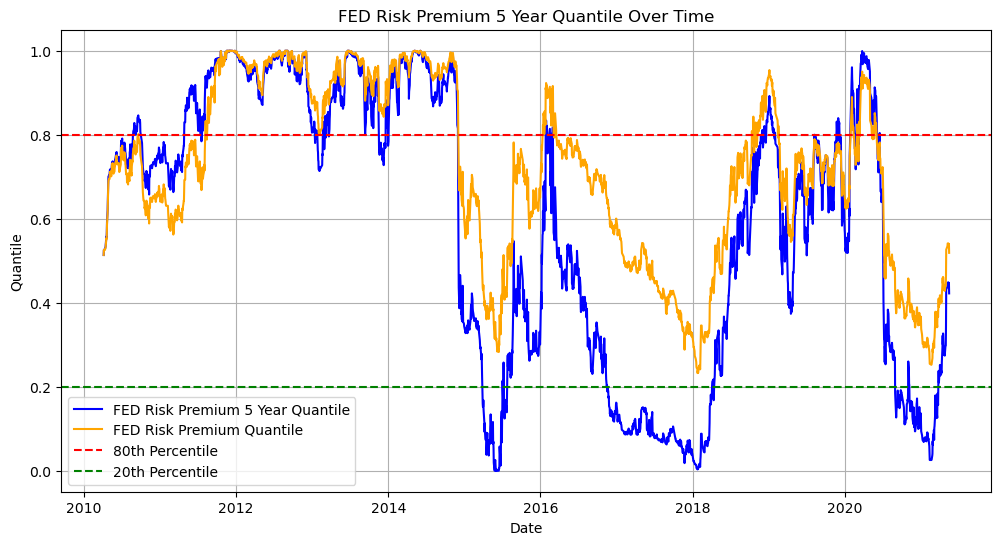

In [543]:
# plot the fed value quantile over time
plt.figure(figsize=(12,6))  
plt.plot(feddata['date'], feddata['FED_quantile_5y'], label='FED Risk Premium 5 Year Quantile', color='blue')
plt.plot(feddata['date'], feddata['FED_quantile'], label='FED Risk Premium Quantile', color='orange')
plt.axhline(y=0.8, color='r', linestyle='--', label='80th Percentile')
plt.axhline(y=0.2, color='g', linestyle='--', label='20th Percentile')
plt.title('FED Risk Premium 5 Year Quantile Over Time') 
plt.xlabel('Date')
plt.ylabel('Quantile')
plt.legend()
plt.grid()
plt.show()


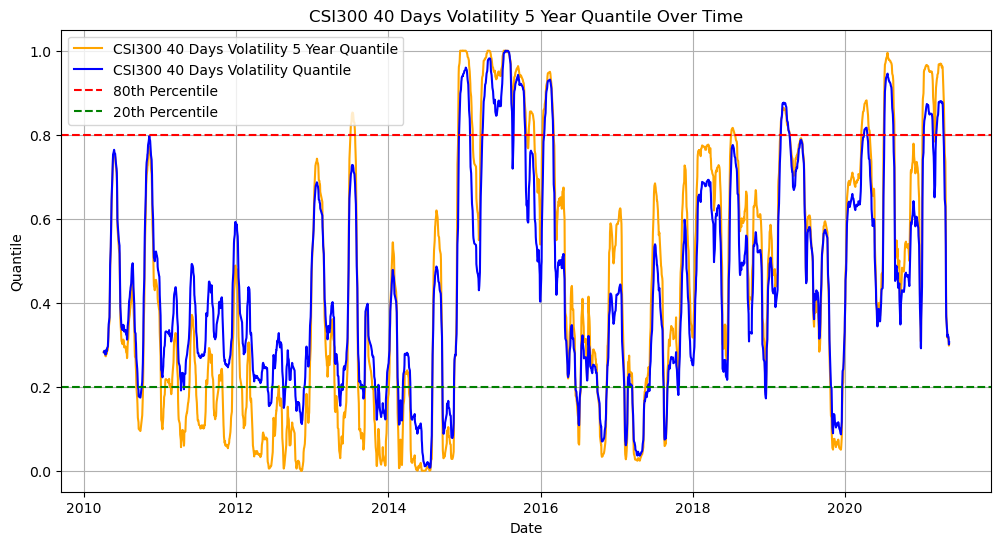

In [544]:
# plot the volatility of csi300 40 days quantile over time
plt.figure(figsize=(12,6))
plt.plot(feddata['date'], feddata['csi300_vol_40_quantile_5y'], label='CSI300 40 Days Volatility 5 Year Quantile', color='orange')
plt.plot(feddata['date'], feddata['csi300_vol_40_quantile'], label='CSI300 40 Days Volatility Quantile', color='blue')
plt.axhline(y=0.8, color='r', linestyle='--', label='80th Percentile')
plt.axhline(y=0.2, color='g', linestyle='--', label='20th Percentile')
plt.title('CSI300 40 Days Volatility 5 Year Quantile Over Time')    
plt.xlabel('Date')
plt.ylabel('Quantile')
plt.legend()
plt.grid()
plt.show()


In [270]:
# get the correlation between fed risk premium and volatility of csi300 both for 40 days and 120 days
corr = feddata.loc[1216:,['csi300', 'csi300_return','FED','FED_quantile_5y', 'csi300_vol_40','csi300_vol_120', 'csi300_vol_40_quantile_5y']].corr()


In [271]:
corr

,csi300,csi300_return,FED,FED_quantile_5y,csi300_vol_40,csi300_vol_120,csi300_vol_40_quantile_5y
csi300,1.000000,0.043957,-0.616124,-0.769373,0.397922,0.439037,0.602800
csi300_return,0.043957,1.000000,-0.019941,-0.039940,0.004769,-0.004215,0.013544
FED,-0.616124,-0.019941,1.000000,0.648413,-0.292755,-0.327361,-0.298563
FED_quantile_5y,-0.769373,-0.039940,0.648413,1.000000,-0.279695,-0.372787,-0.476042
csi300_vol_40,0.397922,0.004769,-0.292755,-0.279695,1.000000,0.706652,0.800461
csi300_vol_120,0.439037,-0.004215,-0.327361,-0.372787,0.706652,1.000000,0.643257
csi300_vol_40_quantile_5y,0.602800,0.013544,-0.298563,-0.476042,0.800461,0.643257,1.000000


In [545]:
feddata_monthly = feddata.copy()

In [546]:
feddata_monthly2 = feddata.copy()

In [91]:
feddata.columns

Index(['date', 'csi300', 'FED', 'CBA00201', 'bond_return', 'FED_MA5',
       'FED_MA20', 'csi300_MA5', 'csi300_MA20', 'csi300_vol_40',
       'csi300_vol_120', 'csi300_return', 'FED_quantile_5y',
       'csi300_vol_40_quantile_5y'],
      dtype='object')

# Strategy 

## Strategy 1 (only based on valuation and volatility quantile)

```mermaid
flowchart TD
    A[Start] --> B{Valuation quantile q_val}
    B -- "q_val < 20%" --> E0["Equity weight = 0%"]
    B -- "q_val >= 80%" --> C{Volatility quantile q_vol}
    B -- "20% <= q_val < 80%" --> D{Volatility quantile q_vol}

    C -- "q_vol >= 80%" --> E50["Equity weight = 50%"]
    C -- "q_vol < 80%"  --> E100["Equity weight = 100%"]

    D -- "q_vol >= 80%"      --> E0b["Equity weight = 0%"]
    D -- "20% <= q_vol < 80%" --> Eavg["Equity weight = Value \(score + Vol score\) / 2"]
    D -- "q_vol < 20%"       --> Eval["Equity weight = Value score"]

    E0 --> F["Bond weight = 1 - Equity weight"]
    E50 --> F
    E100 --> F
    E0b --> F
    Eavg --> F
    Eval --> F

```

**Scores (clipped to [0,1]):**
- Value score = (q_val − 0.20) / (0.80 − 0.20)
- Vol score   = (0.80 − q_vol) / (0.80 − 0.20)

**Bond weight** = 1 − Equity weight.

In [583]:
import numpy as np
import pandas as pd
from dataclasses import dataclass


@dataclass
class FedBacktestResult:
    df: pd.DataFrame
    stats: dict

# ---------- Core Backtest ----------

def backtest_fed_model(
    feddata: pd.DataFrame,
    colmap: dict | None = None,
    lower_q: float = 0.20,
    upper_q: float = 0.80,
    start_equity_weight: float | None = None,
    oneway_cost: float = 0.0005,        # 5 bps one-way
    trade_both_legs: bool = True,       # turnover counts both equity & bond legs
    initial_wealth: float = 1.0,
) -> FedBacktestResult:
    """
    Dynamic allocation based on valuation & volatility quantiles (20%/80% bands).
    Positions change at each day's close; day t return uses yesterday's weights.

    Required columns in `feddata` (you can remap with `colmap`):
      - stock return:      'csi300_ret'
      - bond return:       'bond_ret'
      - value quantile:    'FED_quantile_5y'   (0..1 or 0..100)
      - vol quantile:      'csi300_vol_40_quantile_5y'           (0..1 or 0..100)

    Appends these columns:
      value_quantile, vol_quantile, value_score, vol_score,
      csi300_position, bond_position, equity_weight_prev,
      turnover, tx_cost, port_ret,
      wealth_comp, wealth_add, drawdown, cum_max_wealth, net_wealth
    """
    if colmap is None:
        colmap = {
            'stock_ret': 'csi300_return',
            'bond_ret': 'bond_return',
            'value_quantile': 'FED_quantile_5y',
            'vol_quantile': 'csi300_vol_40_quantile_5y',
            'close': 'csi300' 
        }

    df = feddata.copy()

    # Normalize returns and quantiles to decimals
    stock_ret = df[colmap['stock_ret']]
    bond_ret  = df[colmap['bond_ret']]
    value_q   = df[colmap['value_quantile']]
    vol_q     = df[colmap['vol_quantile']]

    # Scores in the middle band [lower_q, upper_q]
    band = (upper_q - lower_q)
    value_score = ((value_q - lower_q) / band).clip(0.0, 1.0)
    vol_score   = ((upper_q - vol_q) / band).clip(0.0, 1.0)  # lower vol => higher score

    # Equity weight decision tree (per slide)
    w = np.where(
        value_q < lower_q, 0.0,
        np.where(
            value_q >= upper_q,
            np.where(vol_q >= upper_q, 0.5, 1.0),
            np.where(
                vol_q >= upper_q, 0.0,
                np.where(vol_q >= lower_q, (value_score + vol_score) / 2.0, value_score)
            )
        )
    )
     
    w = pd.Series(w, index=df.index, name='csi300_position')
    # find the first row where the strategy starts, i.e. w is has a value
    start_label = w.first_valid_index()
    start_idx = df.index.get_loc(start_label)   # integer position
    w_bond = (1.0 - w).rename('bond_position')

    # Yesterday's weight governs today's P&L
    if start_equity_weight is None:
        w_prev = w.shift(1)
        if len(w) > 0:
            w_prev.iloc[0] = w.iloc[0]  # no cost on the first day
    else:
        w_prev = w.shift(1).fillna(float(start_equity_weight))

    
    # Turnover & transaction cost
    delta = (w - w_prev).abs()
    turnover_mult = 2.0 if trade_both_legs else 1.0
    turnover = turnover_mult * delta
    tx_cost = oneway_cost * turnover

    # Portfolio return (gross minus costs)
    w_prev_f = w_prev.fillna(w.iloc[0] if len(w) else 0.0)
    port_ret_gross = w_prev_f * stock_ret + (1.0 - w_prev_f) * bond_ret
    port_ret = port_ret_gross - tx_cost

    # Wealth series (additive & compounded)
    wealth_comp = (1.0 + port_ret).cumprod() * initial_wealth
    wealth_add  = initial_wealth + port_ret.cumsum()
    # initialize first wealth values if needed
    if start_idx > 0 and len(wealth_comp) > 0:
        wealth_comp.iloc[start_idx] = initial_wealth
        wealth_add.iloc[start_idx] = initial_wealth
    
    # Drawdown on compounded wealth
    cum_max_comp = wealth_comp.cummax()
    drawdown_comp = wealth_comp / cum_max_comp - 1.0
    max_dd_comp = float(drawdown_comp.min()) if len(drawdown_comp) else np.nan

    # Drawdown on additive wealth
    cum_max_add = wealth_add.cummax()
    drawdown_add = wealth_add / cum_max_add - 1.0
    max_dd_add = float(drawdown_add.min()) if len(drawdown_add) else np.nan

    # ============= Benchmark (constant 60/40) =============
    benchmark_ret = pd.Series(np.nan, index=df.index, dtype=float)
    benchmark_ret.iloc[start_idx:] = 0.6*stock_ret.iloc[start_idx:] + 0.4* bond_ret.iloc[start_idx:]  # 60% equity, 40% bond
    benchmark_ret.iloc[start_idx] = 0.0  # no cost on first active day
    benchmark_add = initial_wealth + benchmark_ret.cumsum()
    benchmark_comp = (1.0 + benchmark_ret).cumprod() * initial_wealth
    bencmark_cum_max_bench = benchmark_comp.cummax()
    drawdown_bench_comp = benchmark_comp / bencmark_cum_max_bench - 1.0
    max_dd_bench_comp = float(drawdown_bench_comp.min()) if len(drawdown_bench_comp) else np.nan
    benchmark_cum_max_add = benchmark_add.cummax()
    drawdown_bench_add = benchmark_add / benchmark_cum_max_add - 1.0
    max_dd_bench_add = float(drawdown_bench_add.min()) if len(drawdown_bench_add) else np.nan

    # Append columns
    df['value_quantile']     = value_q
    df['vol_quantile']       = vol_q
    df['value_score']        = value_score
    df['vol_score']          = vol_score
    df['csi300_position']    = w
    df['bond_position']      = w_bond
    df['equity_weight_prev'] = w_prev
    df['turnover']           = turnover
    df['tx_cost']            = tx_cost
    df['port_ret']           = port_ret
    df['wealth_add']         = wealth_add
    df['drawdown_add']       = drawdown_add
    #df['cum_max_wealth_add'] = cum_max_add
    df['wealth_comp']        = wealth_comp
    df['drawdown_comp']      = drawdown_comp
    #df['cum_max_wealth_comp']= cum_max_comp
    df['benchmark_add']      = benchmark_add
    df['benchmark_comp']     = benchmark_comp
    df['benchmark_drawdown_add'] = drawdown_bench_add
    df['benchmark_drawdown_comp'] = drawdown_bench_comp

    stats = {
        'final_wealth_add' : float(wealth_add.iloc[-1])  if len(wealth_add)  else np.nan,
        'final_wealth_comp': float(wealth_comp.iloc[-1]) if len(wealth_comp) else np.nan,
        'max_drawdown_add' : max_dd_add,
        'max_drawdown_comp': max_dd_comp,
        'mean_daily_ret'   : float(port_ret.mean()) if len(port_ret) else np.nan,
        'vol_daily_ret'    : float(port_ret.std(ddof=0)) if len(port_ret) else np.nan,
        'turnover_total'   : float(turnover.sum()) if len(turnover) else np.nan,
        'benchmark_add'    : float(benchmark_add.iloc[-1]) if len(benchmark_add) else np.nan,
        'benchmark_comp'   : float(benchmark_comp.iloc[-1]) if len(benchmark_comp) else np.nan,
        'benchmark_max_drawdown_add': max_dd_bench_add,
        'benchmark_max_drawdown_comp': max_dd_bench_comp,
    }

    return FedBacktestResult(df=df, stats=stats)

# --------- Example (commented) ----------
# res = backtest_fed_model(feddata)
# feddata = res.df
# print(res.stats)


# Yearly Evaluation Function

In [ ]:
def calculate_yearly_stats(
    df: pd.DataFrame,
    wealth_col: str = "WealthComp",  # compounded wealth column (e.g., 1.0, 1.01, ...)
    date_col: str = "date",           # date column name
    rf_rate: float = 0.0,            # annual risk-free, e.g. 0.02 for 2%
    ann_factor: int = 252            # trading days per year
) -> pd.DataFrame:
    """
    For each calendar year:
      - AnnualReturn  : end_of_year_wealth / start_of_year_wealth - 1
      - AnnualVolatility: std(daily returns) * sqrt(# trading days in that year)
      - AnnualSharpe  : (AnnualReturn - rf_rate) / AnnualVolatility
      - MDDComp       : max drawdown within the year from compounded wealth path

    Adds a final 'Overall' row with whole-period metrics:
      - AnnualReturn  :  annualized daily return
      - AnnualVolatility: std(daily returns) * sqrt(ann_factor)
      - AnnualSharpe  : (annualized mean excess) / annualized vol
      - MDDComp       : max drawdown over the full period
      - CAGR over the full period
    Notes:
      - Expects a DatetimeIndex; if the dates are in a column, set that as index first.
      - If the wealth column is named differently (e.g., 'wealth_comp'), pass wealth_col.
    """
    # if date is in a column, set as index first
    if date_col in df.columns:
        df = df.set_index(date_col)     
    else:
        raise ValueError(f"Date column '{date_col}' not found in DataFrame.")
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        raise ValueError("DataFrame must have a DatetimeIndex.")

    # 1) Daily wealth/returns on trading days
    #daily_wealth = df[wealth_col].resample("1D").last().dropna()
    daily_wealth = df[wealth_col]
    daily_ret = daily_wealth.pct_change().dropna()

    # find the first valid index of daily_wealth
    start_label = daily_wealth.first_valid_index()
    start_idx = df.index.get_loc(start_label)   # integer position
    # print(daily_wealth.iloc[start_idx]) # default initial wealth

    results = []

    # Helper: MDD from a wealth series
    def _mdd_from_wealth(w: pd.Series) -> float:
        dd = w / w.cummax() - 1.0
        return float(dd.min()) if len(dd) else np.nan

    # 2) Per-calendar-year metrics
    for year, r in daily_ret.groupby(daily_ret.index.year):
        w_year = daily_wealth[daily_wealth.index.year == year]
        if len(w_year) == 0:
            continue
        
        # for the first year, if it starts mid-year
        if year == start_label.year and start_idx > 0:
            ann_return = float(w_year.iloc[-1] / daily_wealth.iloc[start_idx] - 1.0)
        # Annual return: end/start - 1
        else:
            ann_return = float(w_year.iloc[-1] / w_year.iloc[0] - 1.0)

        # Annual vol (style consistent with  baseline): std * sqrt(N_year)
        n_days = len(r)
        ann_vol = float(r.std() * np.sqrt(n_days)) if n_days > 1 else np.nan

        # Annual sharpe in the same annualized space
        ann_sharpe = (ann_return - rf_rate) / ann_vol if (ann_vol and np.isfinite(ann_vol) and ann_vol > 0) else np.nan

        # Intra-year MDD from compounded wealth within the year
        mdd_comp = _mdd_from_wealth(w_year)

        results.append({
            "Year": int(year),
            "AnnualReturn": ann_return,
            "AnnualVolatility": ann_vol,
            "AnnualSharpe": ann_sharpe,
            "MDDComp": mdd_comp,
            "Days": int(n_days),
        })

    # 3) Whole-period annualized metrics (Overall)
    if not daily_ret.empty:
        n_all = len(daily_ret)
        # CAGR (annualized return)
        start_w, end_w = float(daily_wealth.iloc[start_idx]), float(daily_wealth.iloc[-1])
        cagr = (end_w / start_w) ** (ann_factor/n_all ) - 1.0
        
        # Annualized vol and Sharpe from daily excess returns
        daily_return_mean = daily_ret.mean()
        annualized_ret = daily_return_mean * ann_factor
        daily_return_vol = daily_ret.std(ddof=0)
        annualized_vol = daily_return_vol * np.sqrt(ann_factor)
        # Annualized Sharpe ratio
        annualized_sharpe = (annualized_ret - rf_rate) / annualized_vol if (annualized_vol and np.isfinite(annualized_vol) and annualized_vol > 0) else np.nan

        # Full-period MDD from compounded wealth
        mdd_all = _mdd_from_wealth(daily_wealth)

        results.append({
            "Year": "Overall",
            "AnnualReturn": annualized_ret,
            "AnnualVolatility": annualized_vol,
            "AnnualSharpe": annualized_sharpe,
            "MDDComp": mdd_all,
            "Days": int(n_all),
        })
        results[-1]["CAGR"] = cagr
    return pd.DataFrame(results)


## 5 Year Quantile Daily

In [447]:
res = backtest_fed_model(feddata)
res.stats

{'final_wealth_add': 1.4909467382029948,
 'final_wealth_comp': 1.4690415930627647,
 'max_drawdown_add': -0.3906241057204064,
 'max_drawdown_comp': -0.37067241290486586,
 'mean_daily_ret': 0.00018196691556819676,
 'vol_daily_ret': 0.008876943689927422,
 'turnover_total': 88.01737416457811,
 'benchmark_add': 1.601421986044806,
 'benchmark_comp': 1.6456863759446745,
 'benchmark_max_drawdown_add': -0.2429779845198622,
 'benchmark_max_drawdown_comp': -0.2892526168289251}

In [449]:
calculate_yearly_stats(res.df, wealth_col='wealth_comp', rf_rate=0.03, ann_factor=252)

,Year,AnnualReturn,AnnualVolatility,AnnualSharpe,MDDComp,Days,CAGR
0,2010,0.013711,0.162202,-0.100425,-0.202213,180,NaN
1,2011,-0.259930,0.197373,-1.468950,-0.312126,244,NaN
2,2012,0.097531,0.200688,0.336496,-0.224054,243,NaN
3,2013,-0.058444,0.197171,-0.448563,-0.193401,238,NaN
4,2014,0.252946,0.154350,1.444423,-0.100935,245,NaN
5,2015,0.117647,0.024017,3.649328,-0.011361,244,NaN
6,2016,0.069222,0.075123,0.522101,-0.037722,244,NaN
7,2017,0.002509,0.009904,-2.775783,-0.015731,244,NaN
8,2018,-0.091189,0.101940,-1.188827,-0.126546,243,NaN
9,2019,0.279722,0.103582,2.410850,-0.050510,244,NaN


In [451]:
res.df[['date','csi300_position','bond_position','equity_weight_prev','turnover','tx_cost','port_ret','wealth_comp','wealth_add','drawdown_add','drawdown_comp',
         'benchmark_add',
       'benchmark_comp', 'benchmark_drawdown_add', 'benchmark_drawdown_comp']].iloc[1215:1250]

,date,csi300_position,bond_position,equity_weight_prev,turnover,tx_cost,port_ret,wealth_comp,wealth_add,drawdown_add,drawdown_comp,benchmark_add,benchmark_comp,benchmark_drawdown_add,benchmark_drawdown_comp
1215,2010-04-07,0.693056,0.306944,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
1216,2010-04-08,0.701918,0.298082,0.693056,0.017725,8.862372e-06,-0.008410,0.991590,0.991590,-0.008410,-0.008410,0.992650,0.992650,-0.007350,-0.007350
1217,2010-04-09,0.701210,0.298790,0.701918,0.001417,7.086168e-07,0.006810,0.998342,0.998400,-0.001600,-0.001658,0.998477,0.998434,-0.001523,-0.001566
1218,2010-04-12,0.706832,0.293168,0.701210,0.011245,5.622315e-06,-0.005673,0.992679,0.992727,-0.007273,-0.007321,0.993666,0.993631,-0.006334,-0.006369
1219,2010-04-13,0.709667,0.290333,0.706832,0.005669,2.834467e-06,0.008656,1.001272,1.001383,0.000000,0.000000,1.001105,1.001022,0.000000,0.000000
1220,2010-04-14,0.713140,0.286860,0.709667,0.006946,3.473155e-06,0.002553,1.003828,1.003936,0.000000,0.000000,1.003292,1.003212,0.000000,0.000000
1221,2010-04-15,0.714510,0.285490,0.713140,0.002741,1.370614e-06,-0.001840,1.001981,1.002096,-0.001833,-0.001840,1.001786,1.001701,-0.001501,-0.001506
1222,2010-04-16,0.717298,0.282702,0.714510,0.005576,2.787848e-06,-0.007988,0.993977,0.994108,-0.009789,-0.009813,0.995117,0.995021,-0.008148,-0.008165
1223,2010-04-19,0.727415,0.272585,0.717298,0.020233,1.011644e-05,-0.038195,0.956013,0.955914,-0.047834,-0.047633,0.963330,0.963392,-0.039831,-0.039692
1224,2010-04-20,0.727960,0.272040,0.727415,0.001091,5.454484e-07,-0.000546,0.955491,0.955368,-0.048378,-0.048153,0.962979,0.963053,-0.040181,-0.040030


In [452]:
# find the first few rows where the strategy starts
res.df[res.df['csi300_position']>0].head()

,date,csi300,FED,CBA00201,bond_return,csi300_MA5,csi300_MA40,csi300_vol_40,csi300_return,FED_quantile_5y,...,tx_cost,port_ret,wealth_add,drawdown_add,wealth_comp,drawdown_comp,benchmark_add,benchmark_comp,benchmark_drawdown_add,benchmark_drawdown_comp
1215,2010-04-07,3386.949,0.003791,133.8392,-0.000643,3387.3964,3274.130325,66.304469,-0.005344,0.513980,...,NaN,NaN,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
1216,2010-04-08,3346.744,0.004816,133.7631,-0.000569,3387.6238,3277.031050,66.891858,-0.011871,0.526316,...,8.862372e-06,-0.008410,0.991590,-0.008410,0.991590,-0.008410,0.992650,0.992650,-0.007350,-0.007350
1217,2010-04-09,3379.170,0.004610,133.7676,0.000034,3385.0708,3281.040250,68.107212,0.009689,0.526316,...,7.086168e-07,0.006810,0.998400,-0.001600,0.998342,-0.001658,0.998477,0.998434,-0.001523,-0.001566
1218,2010-04-12,3351.478,0.005096,133.8030,0.000265,3373.8972,3286.000025,65.732670,-0.008195,0.527961,...,5.622315e-06,-0.005673,0.992727,-0.007273,0.992679,-0.007321,0.993666,0.993631,-0.006334,-0.006369
1219,2010-04-13,3391.716,0.005049,133.8818,0.000589,3371.2114,3292.018225,64.053151,0.012006,0.527961,...,2.834467e-06,0.008656,1.001383,0.000000,1.001272,0.000000,1.001105,1.001022,0.000000,0.000000


In [453]:
feddata = res.df

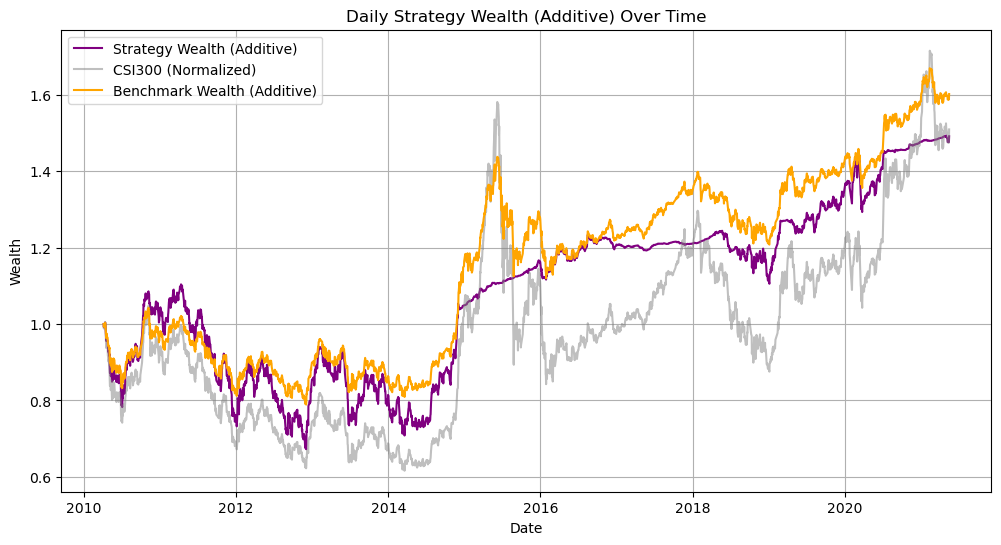

In [454]:
# plot wealth_add, csi300, and benchmark_add close against date 
plt.figure(figsize=(12,6))
plt.plot(feddata['date'], feddata['wealth_add'], label='Strategy Wealth (Additive)', color='purple')
plt.plot(feddata['date'].iloc[1215:], feddata['csi300'].iloc[1215:]/feddata['csi300'].iloc[1215], label='CSI300 (Normalized)', color='gray', alpha=0.5)
plt.plot(feddata['date'].iloc[1215:], feddata['benchmark_add'].iloc[1215:]/feddata['benchmark_add'].iloc[1215], label='Benchmark Wealth (Additive)', color='orange')
plt.plot()
plt.title('Daily Strategy Wealth (Additive) Over Time')
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.legend()
plt.grid()
plt.show()


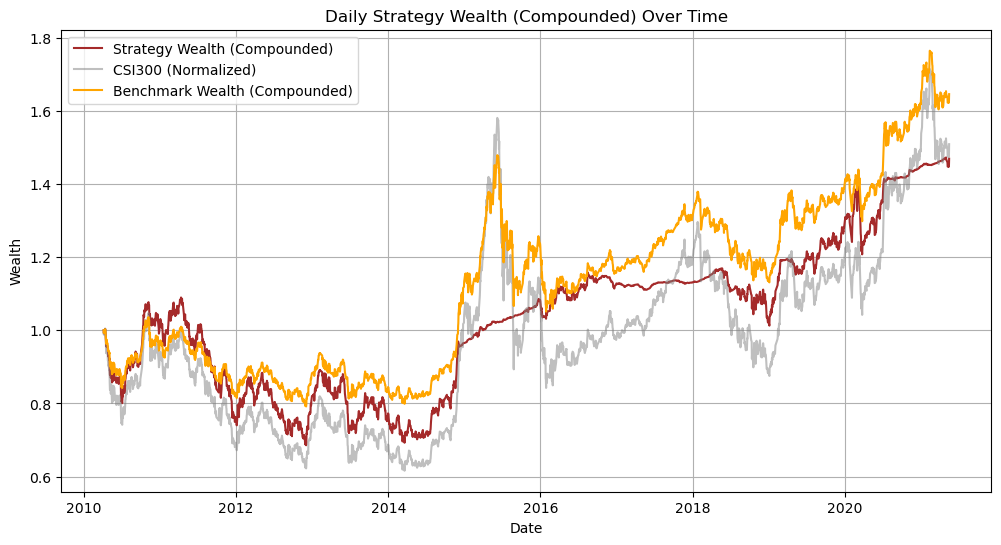

In [455]:
# plot wealth_comp, csi300, and benchmark close against date
plt.figure(figsize=(12,6))
plt.plot(feddata['date'], feddata['wealth_comp'], label='Strategy Wealth (Compounded)', color='brown')
plt.plot(feddata['date'].iloc[1215:], feddata['csi300'].iloc[1215:]/feddata['csi300'].iloc[1215], label='CSI300 (Normalized)', color='gray', alpha=0.5)
plt.plot(feddata['date'].iloc[1215:], feddata['benchmark_comp'].iloc[1215:]/feddata['benchmark_comp'].iloc[1215], label='Benchmark Wealth (Compounded)', color='orange')
plt.title('Daily Strategy Wealth (Compounded) Over Time')
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.legend()
plt.grid()
plt.show()


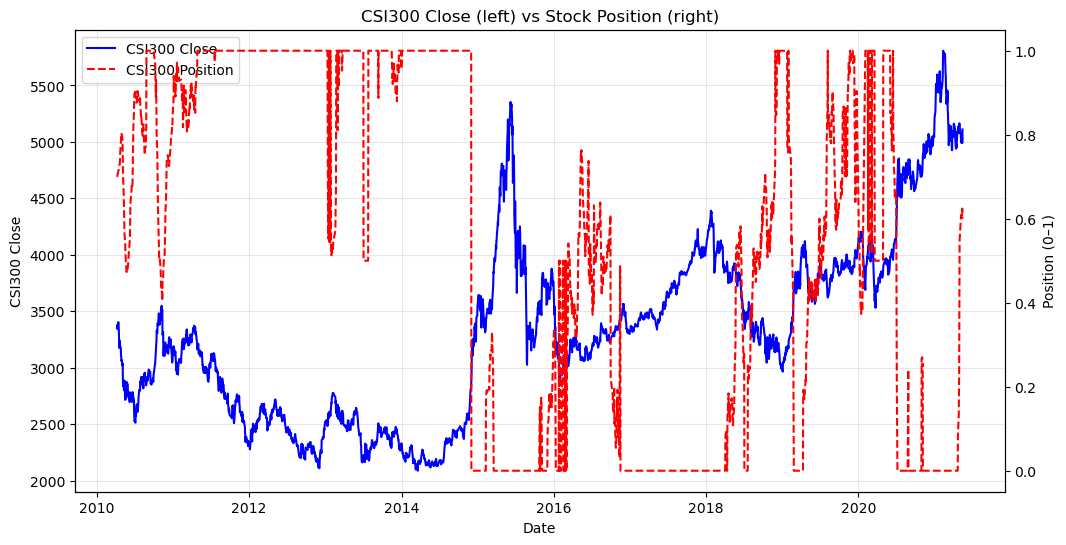

In [456]:
# plot stock position and csi300 close against date
# set csi300 close left y-axis and stock position right y-axis
# Left y-axis: CSI300 close
x = feddata['date'].iloc[1216:]
y_close = feddata['csi300'].iloc[1216:]
y_pos = feddata['csi300_position'].iloc[1216:]

fig, ax1 = plt.subplots(figsize=(12,6))

l1, = ax1.plot(x, y_close, label='CSI300 Close', linewidth=1.5, color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('CSI300 Close')
ax1.grid(True, alpha=0.3)

# Right y-axis: stock position
ax2 = ax1.twinx()
l2, = ax2.plot(x, y_pos, label='CSI300 Position', linestyle='--', linewidth=1.5, color='red')
ax2.set_ylabel('Position (0–1)')
ax2.set_ylim(-0.05, 1.05)

# One legend
lines = [l1, l2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('CSI300 Close (left) vs Stock Position (right)')
plt.show()

## All Historical Quantile Daily

In [547]:
# use historical quantile data to backtest the model
colmap = {
    'stock_ret': 'csi300_return',
    'bond_ret': 'bond_return',
    'value_quantile': 'FED_quantile',
    'vol_quantile': 'csi300_vol_40_quantile',
}    
res2 = backtest_fed_model(feddata, colmap=colmap)
feddata = res2.df
res2.stats

{'final_wealth_add': 1.6137131564499694,
 'final_wealth_comp': 1.6230350877928965,
 'max_drawdown_add': -0.3790556664888767,
 'max_drawdown_comp': -0.36393407362472585,
 'mean_daily_ret': 0.0002274696651037695,
 'vol_daily_ret': 0.009790458538521209,
 'turnover_total': 83.68290376461314,
 'benchmark_add': 1.601421986044806,
 'benchmark_comp': 1.6456863759446745,
 'benchmark_max_drawdown_add': -0.2429779845198622,
 'benchmark_max_drawdown_comp': -0.2892526168289251}

In [548]:
# 
calculate_yearly_stats(feddata, wealth_col='wealth_comp', rf_rate=0.03, ann_factor=252)

,Year,AnnualReturn,AnnualVolatility,AnnualSharpe,MDDComp,Days,CAGR
0,2010,0.004703,0.149839,-0.168825,-0.196580,180,NaN
1,2011,-0.251089,0.182730,-1.538278,-0.294844,244,NaN
2,2012,0.097531,0.200688,0.336496,-0.224054,243,NaN
3,2013,-0.080440,0.215827,-0.511707,-0.221594,238,NaN
4,2014,0.342816,0.157788,1.982508,-0.101212,245,NaN
5,2015,0.090157,0.093238,0.645199,-0.091681,244,NaN
6,2016,0.029258,0.155463,-0.004773,-0.106696,244,NaN
7,2017,0.095146,0.049931,1.304734,-0.032668,244,NaN
8,2018,-0.122376,0.147354,-1.034078,-0.159709,243,NaN
9,2019,0.281049,0.116973,2.146209,-0.059500,244,NaN


In [326]:
# csi300 stats
calculate_yearly_stats(feddata.iloc[1215:], wealth_col='csi300', rf_rate=0.03, ann_factor=252)

,Year,AnnualReturn,AnnualVolatility,AnnualSharpe,MDDComp,Days,CAGR
0,2010,-0.076378,0.224951,-0.472894,-0.261790,180,NaN
1,2011,-0.264584,0.203331,-1.448796,-0.316425,244,NaN
2,2012,0.097531,0.200688,0.336496,-0.224054,243,NaN
3,2013,-0.077001,0.215943,-0.495507,-0.221594,238,NaN
4,2014,0.521851,0.189854,2.590679,-0.101212,245,NaN
5,2015,0.024568,0.387946,-0.014003,-0.434846,244,NaN
6,2016,-0.045829,0.218683,-0.346756,-0.193811,244,NaN
7,2017,0.206039,0.099842,1.763168,-0.060675,244,NaN
8,2018,-0.263431,0.210383,-1.394748,-0.318774,243,NaN
9,2019,0.379536,0.195362,1.789177,-0.134915,244,NaN


In [459]:
feddata.columns

Index(['date', 'csi300', 'FED', 'CBA00201', 'bond_return', 'csi300_MA5',
       'csi300_MA40', 'csi300_vol_40', 'csi300_return', 'FED_quantile_5y',
       'csi300_vol_40_quantile_5y', 'FED_quantile', 'csi300_vol_40_quantile',
       'value_quantile', 'vol_quantile', 'value_score', 'vol_score',
       'csi300_position', 'bond_position', 'equity_weight_prev', 'turnover',
       'tx_cost', 'port_ret', 'wealth_add', 'drawdown_add', 'wealth_comp',
       'drawdown_comp', 'benchmark_add', 'benchmark_comp',
       'benchmark_drawdown_add', 'benchmark_drawdown_comp'],
      dtype='object')

In [460]:
feddata[['date','csi300_position','bond_position','equity_weight_prev','turnover','tx_cost','port_ret','wealth_comp','wealth_add','drawdown_add','drawdown_comp',
         'benchmark_add',
       'benchmark_comp', 'benchmark_drawdown_add', 'benchmark_drawdown_comp']].iloc[1215:1250]

,date,csi300_position,bond_position,equity_weight_prev,turnover,tx_cost,port_ret,wealth_comp,wealth_add,drawdown_add,drawdown_comp,benchmark_add,benchmark_comp,benchmark_drawdown_add,benchmark_drawdown_comp
1215,2010-04-07,0.692902,0.307098,0.690997,0.003811,1.905272e-06,-0.003893,1.208243,1.245316,-0.016532,-0.022849,1.980444,2.409012,-0.078322,-0.209412
1216,2010-04-08,0.700899,0.299101,0.692902,0.015994,7.996816e-06,-0.008408,1.198085,1.236909,-0.023172,-0.031064,1.973094,2.391306,-0.081742,-0.215223
1217,2010-04-09,0.699327,0.300673,0.700899,0.003144,1.572123e-06,0.006799,1.206231,1.243708,-0.017802,-0.024476,1.978921,2.405240,-0.079030,-0.210650
1218,2010-04-12,0.704068,0.295932,0.699327,0.009483,4.741266e-06,-0.005656,1.199408,1.238052,-0.022269,-0.029994,1.974110,2.393668,-0.081269,-0.214448
1219,2010-04-13,0.706024,0.293976,0.704068,0.003912,1.955937e-06,0.008625,1.209754,1.246677,-0.015457,-0.021627,1.981549,2.411475,-0.077807,-0.208604
1220,2010-04-14,0.708614,0.291386,0.706024,0.005180,2.590071e-06,0.002542,1.212829,1.249219,-0.013450,-0.019140,1.983736,2.416749,-0.076790,-0.206873
1221,2010-04-15,0.709109,0.290891,0.708614,0.000990,4.949934e-07,-0.001826,1.210614,1.247393,-0.014892,-0.020931,1.982230,2.413110,-0.077490,-0.208068
1222,2010-04-16,0.711011,0.288989,0.709109,0.003804,1.901869e-06,-0.007925,1.201020,1.239468,-0.021151,-0.028690,1.975561,2.397016,-0.080594,-0.213349
1223,2010-04-19,0.720197,0.279803,0.711011,0.018372,9.186157e-06,-0.037851,1.155561,1.201618,-0.051042,-0.065455,1.943774,2.320822,-0.095387,-0.238354
1224,2010-04-20,0.719867,0.280133,0.720197,0.000660,3.299891e-07,-0.000535,1.154943,1.201083,-0.051465,-0.065954,1.943423,2.320007,-0.095551,-0.238622


In [461]:
# find the first few rows where the strategy starts
feddata[feddata['csi300_position']>0].head()

,date,csi300,FED,CBA00201,bond_return,csi300_MA5,csi300_MA40,csi300_vol_40,csi300_return,FED_quantile_5y,...,tx_cost,port_ret,wealth_add,drawdown_add,wealth_comp,drawdown_comp,benchmark_add,benchmark_comp,benchmark_drawdown_add,benchmark_drawdown_comp
0,2005-04-08,1003.445,0.020882,109.228,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0000,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,0.000000
1,2005-04-11,995.421,0.022335,109.379,0.001382,NaN,NaN,NaN,-0.007996,NaN,...,0.0000,-0.007996,0.992004,0.000000,0.992004,0.000000,0.995755,0.995755,-0.004245,-0.004245
2,2005-04-12,978.697,0.025016,109.381,0.000018,NaN,NaN,NaN,-0.016801,NaN,...,0.0000,-0.016801,0.975203,-0.016936,0.975337,-0.016801,0.985682,0.985725,-0.014318,-0.014275
3,2005-04-13,1000.900,0.021253,109.535,0.001408,NaN,NaN,NaN,0.022686,NaN,...,0.0005,0.022186,0.997389,0.000000,0.996976,0.000000,0.999857,0.999697,-0.000143,-0.000303
4,2005-04-14,986.975,0.023021,109.792,0.002346,993.0876,NaN,NaN,-0.013912,NaN,...,0.0005,-0.006283,0.991106,-0.006300,0.990712,-0.006283,0.992448,0.992290,-0.007552,-0.007710


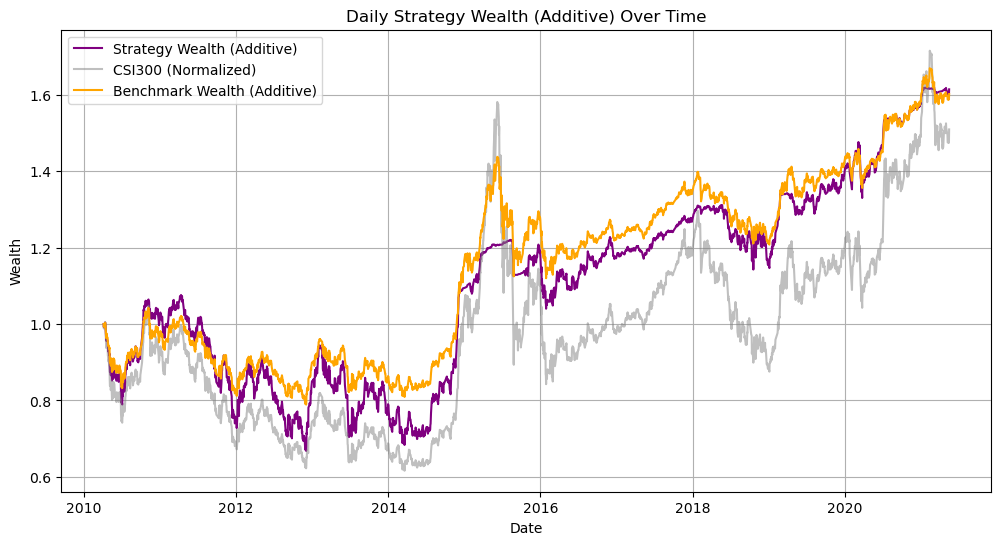

In [550]:
# plot wealth_add, csi300, and benchmark_add close against date 
plt.figure(figsize=(12,6))
plt.plot(feddata['date'], feddata['wealth_add'], label='Strategy Wealth (Additive)', color='purple')
plt.plot(feddata['date'].iloc[1215:], feddata['csi300'].iloc[1215:]/feddata['csi300'].iloc[1215], label='CSI300 (Normalized)', color='gray', alpha=0.5)
plt.plot(feddata['date'].iloc[1215:], feddata['benchmark_add'].iloc[1215:]/feddata['benchmark_add'].iloc[1215], label='Benchmark Wealth (Additive)', color='orange')
plt.plot()
plt.title('Daily Strategy Wealth (Additive) Over Time')
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.legend()
plt.grid()
plt.show()


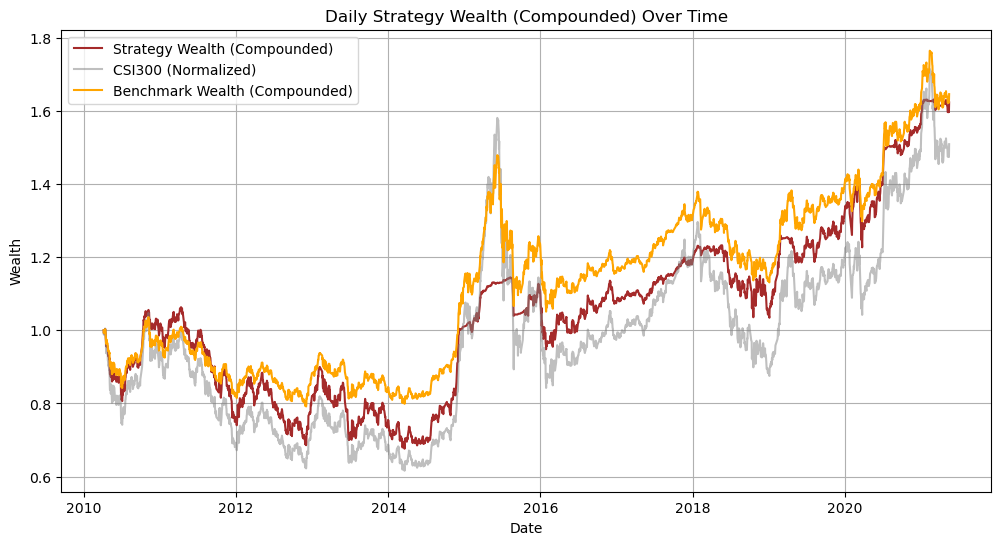

In [551]:
# plot wealth_comp, csi300, and benchmark close against date
plt.figure(figsize=(12,6))
plt.plot(feddata['date'], feddata['wealth_comp'], label='Strategy Wealth (Compounded)', color='brown')
plt.plot(feddata['date'].iloc[1215:], feddata['csi300'].iloc[1215:]/feddata['csi300'].iloc[1215], label='CSI300 (Normalized)', color='gray', alpha=0.5)
plt.plot(feddata['date'].iloc[1215:], feddata['benchmark_comp'].iloc[1215:]/feddata['benchmark_comp'].iloc[1215], label='Benchmark Wealth (Compounded)', color='orange')
plt.title('Daily Strategy Wealth (Compounded) Over Time')
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.legend()
plt.grid()
plt.show()


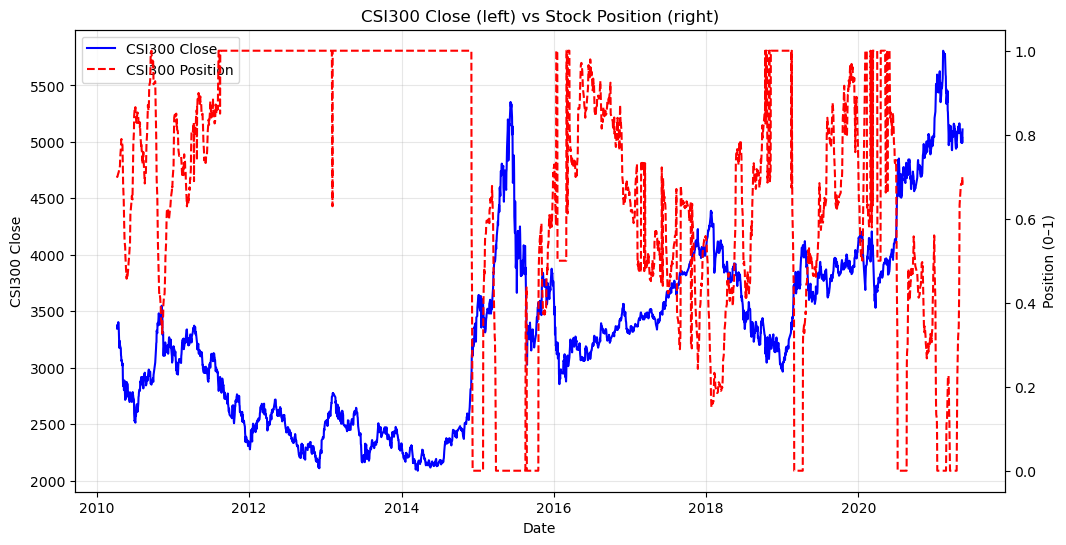

In [552]:
# plot stock position and csi300 close against date
# set csi300 close left y-axis and stock position right y-axis
# Left y-axis: CSI300 close
x = feddata['date'].iloc[1216:]
y_close = feddata['csi300'].iloc[1216:]
y_pos = feddata['csi300_position'].iloc[1216:]

fig, ax1 = plt.subplots(figsize=(12,6))

l1, = ax1.plot(x, y_close, label='CSI300 Close', linewidth=1.5, color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('CSI300 Close')
ax1.grid(True, alpha=0.3)

# Right y-axis: stock position
ax2 = ax1.twinx()
l2, = ax2.plot(x, y_pos, label='CSI300 Position', linestyle='--', linewidth=1.5, color='red')
ax2.set_ylabel('Position (0–1)')
ax2.set_ylim(-0.05, 1.05)

# One legend
lines = [l1, l2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('CSI300 Close (left) vs Stock Position (right)')
plt.show()

## Analysis

In [33]:
feddata.columns

Index(['date', 'csi300', 'FED', 'CBA00201', 'bond_return', 'FED_MA5',
       'FED_MA20', 'csi300_MA5', 'csi300_MA20', 'csi300_vol_40',
       'csi300_vol_120', 'csi300_return', 'FED_quantile_5y',
       'csi300_vol_40_quantile_5y', 'value_quantile', 'vol_quantile',
       'value_score', 'vol_score', 'csi300_position', 'bond_position',
       'equity_weight_prev', 'turnover', 'tx_cost', 'port_ret', 'wealth_comp',
       'wealth_add', 'drawdown_add', 'cum_max_wealth_add', 'drawdown_comp',
       'cum_max_wealth_comp', 'benchmark_add', 'benchmark_comp',
       'benchmark_drawdown_add', 'benchmark_drawdown_comp'],
      dtype='object')

In [35]:
col = ['date', 'csi300', 'FED', 'CBA00201', 'bond_return','csi300_vol_40',
       'csi300_return', 'FED_quantile_5y',
       'csi300_vol_40_quantile_5y', 
       'value_score', 'vol_score', 'csi300_position', 'bond_position',
       'equity_weight_prev', 'turnover', 'tx_cost', 'port_ret', 'wealth_comp',
       'wealth_add', 'drawdown_add',  'drawdown_comp',
        'benchmark_add', 'benchmark_comp',
       'benchmark_drawdown_add', 'benchmark_drawdown_comp']

# Strategy 2 (Monthly Position Change + Limits Turnover Rate between 2 months) 

## Monthly Allocation

In [ ]:
import numpy as np
import pandas as pd
from dataclasses import dataclass

@dataclass
class FedBacktestResult:
    df: pd.DataFrame
    stats: dict
    stats2: dict | None = None  # optional second stats dict for additional metrics

# ---------- Monthly Backtest with 10% cap ----------

def backtest_fed_model_monthly(
    feddata: pd.DataFrame,
    colmap: dict | None = None,
    lower_q: float = 0.20,
    upper_q: float = 0.80,
    oneway_cost: float = 0.0005,        # 5 bps one-way
    trade_both_legs: bool = True,       # turnover counts both equity & bond legs
    initial_wealth: float = 1.0,
    max_rebalance_step: float = 0.10,   # cap per month: |Δw| <= 10%
) -> FedBacktestResult:
    """
    Monthly rebalancing at the last trading day of each month with a 10% step cap.
    Day 1 weight = rule-based target (no initial cost).
    Day t P&L uses *yesterday's realized* weight; turnover cost charged on weight change.

    Required columns in `feddata` (you can remap with `colmap`):
      - stock return:      'csi300_return'                 (decimal)
      - bond return:       'bond_return'                   (decimal)
      - value quantile:    'FED_quantile_5y'               ([0,1])
      - vol quantile:      'csi300_vol_40_quantile_5y'     ([0,1])

    Appended columns:
      value_quantile, vol_quantile, value_score, vol_score,
      equity_weight_target, csi300_position, bond_position, equity_weight_prev,
      turnover, tx_cost, port_ret,
      wealth_comp, wealth_add, drawdown_add, drawdown_comp,
      benchmark_add, benchmark_comp, benchmark_drawdown_add, benchmark_drawdown_comp
    """
    if colmap is None:
        colmap = {
            'stock_ret': 'csi300_return',
            'bond_ret': 'bond_return',
            'value_quantile': 'FED_quantile_5y',
            'vol_quantile': 'csi300_vol_40_quantile_5y',
            'close': 'csi300',
            'fed_value': 'FED',   # if missing, we will fallback to value_quantile
            'ma40': 'csi300_MA40',  # optional
        }

    df = feddata.copy()

    # --- Use a date column for month-end detection; keep original index as-is ---
    date_col = 'date'  # default column name for date
    if date_col not in df.columns:
        raise ValueError(f"Expected a '{date_col}' column for month-end detection.")
    date_ser = pd.to_datetime(df[date_col], errors='raise')

    # Flag last row within each month (relative to available trading days)
    last_in_month = date_ser.groupby(date_ser.dt.to_period('M')).transform('max')
    is_month_end = (date_ser == last_in_month)  # boolean Series aligned with df rows
    
    # --- Inputs (assumed already in correct units) ---
    stock_ret = df[colmap['stock_ret']].astype(float)
    bond_ret  = df[colmap['bond_ret']].astype(float)
    value_q   = df[colmap['value_quantile']].astype(float).clip(0.0, 1.0)
    vol_q     = df[colmap['vol_quantile']].astype(float).clip(0.0, 1.0)

    # --- Scores in [lower_q, upper_q] band ---
    band = (upper_q - lower_q)
    value_score = ((value_q - lower_q) / band).clip(0.0, 1.0)
    vol_score   = ((upper_q - vol_q) / band).clip(0.0, 1.0)  # lower vol => higher score

    # --- Target equity weight (decision tree) ---
    w_target = np.where(
        value_q < lower_q, 0.0,
        np.where(
            value_q >= upper_q,
            np.where(vol_q >= upper_q, 0.5, 1.0),
            np.where(
                vol_q >= upper_q, 0.0,
                np.where(vol_q >= lower_q, (value_score + vol_score) / 2.0, value_score)
            )
        )
    )
    w_target = pd.Series(w_target, index=df.index, name='equity_weight_target')

    # --- Realized equity weight with MONTHLY rebalance and cap |Δw| <= max_rebalance_step ---
    w = pd.Series(index=df.index, dtype=float, name='csi300_position')
    # find the first row where the strategy starts, i.e. w is has a value
    start_label = w_target.first_valid_index()
    start_idx = df.index.get_loc(start_label)   # integer position

    prev = None
    for i in range(len(df.index)):
        tgt = float(w_target.iat[i])
        if i < start_idx:
        # before strategy starts: keep NaN (no position)
            continue

        if i == start_idx:
            prev = float(np.clip(tgt, 0.0, 1.0))      # initialize to rule-based target (no cost)
            w.iat[i] = prev
            continue

        if bool(is_month_end.iat[i]):
            diff = tgt - prev
            step = float(np.clip(diff, -max_rebalance_step, max_rebalance_step))
            prev = float(np.clip(prev + step, 0.0, 1.0))
        # within the month: hold
        w.iat[i] = prev

    w_bond = (1.0 - w).rename('bond_position')

    # --- Costs & PnL timing ---
    w_prev = w.shift(1).fillna(w.iloc[0])                   # yesterday's realized weight
    delta = (w - w_prev).abs()
    turnover_mult = 2.0 if trade_both_legs else 1.0
    turnover = turnover_mult * delta
    tx_cost = oneway_cost * turnover

    port_ret_gross = w_prev * stock_ret + (1.0 - w_prev) * bond_ret
    port_ret = port_ret_gross - tx_cost
    if start_idx > 0 and len(port_ret) > 0:
        port_ret.iloc[start_idx] = 0.0

    # --- Wealth series (strategy) ---
    wealth_comp = (1.0 + port_ret).cumprod() * initial_wealth
    wealth_add  = initial_wealth + port_ret.cumsum()
    # initialize first wealth values if needed
    if start_idx > 0 and len(wealth_comp) > 0:
        wealth_comp.iloc[start_idx] = initial_wealth
        wealth_add.iloc[start_idx] = initial_wealth

    # Drawdowns
    cum_max_comp = wealth_comp.cummax()
    drawdown_comp = wealth_comp / cum_max_comp - 1.0
    max_dd_comp = float(drawdown_comp.min()) if len(drawdown_comp) else np.nan

    cum_max_add = wealth_add.cummax()
    drawdown_add = wealth_add / cum_max_add - 1.0
    max_dd_add = float(drawdown_add.min()) if len(drawdown_add) else np.nan

    # --- Benchmark (constant 60/40) ---
    benchmark_ret = pd.Series(np.nan, index=df.index, name='benchmark_ret')
    benchmark_ret.iloc[start_idx:] = 0.6 * stock_ret.iloc[start_idx:] + 0.4 * bond_ret.iloc[start_idx:]
    benchmark_ret.iloc[start_idx] = 0.0  # no cost on the first day
    benchmark_add = initial_wealth + benchmark_ret.cumsum()
    benchmark_comp = (1.0 + benchmark_ret).cumprod() * initial_wealth

    benchmark_cum_max_comp = benchmark_comp.cummax()
    drawdown_bench_comp = benchmark_comp / benchmark_cum_max_comp - 1.0
    max_dd_bench_comp = float(drawdown_bench_comp.min()) if len(drawdown_bench_comp) else np.nan

    benchmark_cum_max_add = benchmark_add.cummax()
    drawdown_bench_add = benchmark_add / benchmark_cum_max_add - 1.0
    max_dd_bench_add = float(drawdown_bench_add.min()) if len(drawdown_bench_add) else np.nan

    # --- Append columns ---
    df['value_quantile']            = value_q
    df['vol_quantile']              = vol_q
    df['value_score']               = value_score
    df['vol_score']                 = vol_score
    df['equity_weight_target']      = w_target
    df['csi300_position']           = w
    df['bond_position']             = w_bond
    df['equity_weight_prev']        = w_prev
    df['turnover']                  = turnover
    df['tx_cost']                   = tx_cost
    df['port_ret']                  = port_ret
    df['wealth_comp']               = wealth_comp
    df['wealth_add']                = wealth_add
    df['drawdown_add']              = drawdown_add
    df['drawdown_comp']             = drawdown_comp
    df['benchmark_add']             = benchmark_add
    df['benchmark_comp']            = benchmark_comp
    df['benchmark_drawdown_add']    = drawdown_bench_add
    df['benchmark_drawdown_comp']   = drawdown_bench_comp

    stats = {
        'final_wealth_add'  : float(wealth_add.iloc[-1])  if len(wealth_add)  else np.nan,
        'final_wealth_comp' : float(wealth_comp.iloc[-1]) if len(wealth_comp) else np.nan,
        'max_drawdown_add'  : max_dd_add,
        'max_drawdown_comp' : max_dd_comp,
        'mean_daily_ret'    : float(port_ret.mean()) if len(port_ret) else np.nan,
        'vol_daily_ret'     : float(port_ret.std(ddof=0)) if len(port_ret) else np.nan,
        'turnover_total'    : float(turnover.sum()) if len(turnover) else np.nan,
        'bench_final_comp'  : float(benchmark_comp.iloc[-1]) if len(benchmark_comp) else np.nan,
        'bench_max_dd_comp' : max_dd_bench_comp,
        'bench_max_dd_add'  : max_dd_bench_add,
    }

    return FedBacktestResult(df=df, stats=stats)


def backtest_fed_model_monthly_tri(
    feddata: pd.DataFrame,
    colmap: dict | None = None,
    lower_q: float = 0.20,
    upper_q: float = 0.80,
    oneway_cost: float = 0.0005,        # 5 bps one-way
    trade_both_legs: bool = True,       # turnover counts both equity & bond legs
    initial_wealth: float = 1.0,
    bench_equity_weight: float = 0.60,  # 60/40 benchmark
) -> FedBacktestResult:
    """
    Monthly rebalancing at last trading day with a dynamic turnover cap driven by trend:
      - Strong uptrend  OR strong downtrend  -> cap |Δw| to 3% (0.03)
      - Otherwise                              cap |Δw| to 30% (0.30)

    Strong uptrend at month-end (all must hold):
      1) rule-based target today < rule-based target at previous month-end
      2) FED value today < FED value at previous month-end
      3) Close > 40-day moving average

    Strong downtrend is the opposite (>, >, Close < MA40).

    Strategy starts at the first row where BOTH quantiles exist (handles 5y warmup).
    Day t P&L uses *yesterday's realized* weight; turnover cost charged on weight change.

    Required columns (remap via colmap if needed):
      - stock return:      'csi300_return'                 (decimal)
      - bond return:       'bond_return'                   (decimal)
      - value quantile:    'FED_quantile_5y'               ([0,1])
      - vol quantile:      'csi300_vol_40_quantile_5y'     ([0,1])
      - close price:       'csi300'                        (for MA40 / trend)
      - fed value daily:   'FED_value_daily'               (for trend; falls back to quantile if missing)
      - date column:       'date' (datetime-like)
    """
    if colmap is None:
        colmap = {
            'stock_ret': 'csi300_return',
            'bond_ret': 'bond_return',
            'value_quantile': 'FED_quantile_5y',
            'vol_quantile': 'csi300_vol_40_quantile_5y',
            'close': 'csi300',
            'fed_value': 'FED',   # if missing, we will fallback to value_quantile
            'ma40': 'csi300_MA40',  # optional, if not present we will calculate it
        }

    df = feddata.copy()

    # --- Dates: keep original index; use a date column for month-end detection ---
    date_col = 'date'  # default column name for date
    if date_col not in df.columns:
        raise ValueError(f"Expected a '{date_col}' column for month-end detection.")
    date_ser = pd.to_datetime(df[date_col], errors='raise')

    # Last trading day flag (relative to available rows)
    last_in_month = date_ser.groupby(date_ser.dt.to_period('M')).transform('max')
    is_month_end = (date_ser == last_in_month)  # boolean Series aligned with df rows

    
     # --- Inputs (assumed already in correct units) ---
    stock_ret = df[colmap['stock_ret']].astype(float)
    bond_ret  = df[colmap['bond_ret']].astype(float)
    value_q   = df[colmap['value_quantile']].astype(float).clip(0.0, 1.0)
    vol_q     = df[colmap['vol_quantile']].astype(float).clip(0.0, 1.0)
    if colmap.get('ma40') in df.columns:
        ma40 = df[colmap['ma40']].astype(float)

    # --- Scores in [lower_q, upper_q] band ---
    band = (upper_q - lower_q)
    value_score = ((value_q - lower_q) / band).clip(0.0, 1.0)
    vol_score   = ((upper_q - vol_q) / band).clip(0.0, 1.0)  # lower vol => higher score

    # --- Target equity weight (decision tree) ---
    w_target = np.where(
        value_q < lower_q, 0.0,
        np.where(
            value_q >= upper_q,
            np.where(vol_q >= upper_q, 0.5, 1.0),
            np.where(
                vol_q >= upper_q, 0.0,
                np.where(vol_q >= lower_q, (value_score + vol_score) / 2.0, value_score)
            )
        )
    )
    w_target = pd.Series(w_target, index=df.index, name='equity_weight_target')

    # find the first row where the strategy starts, i.e. w is has a value
    start_label = w_target.first_valid_index()
    start_idx = df.index.get_loc(start_label)   # integer position

    # --- Trend inputs: close, MA40, FED value daily (fallback to quantile if needed) ---
    if colmap.get('close') not in df.columns:
        raise ValueError(f"Close price column '{colmap.get('close')}' not found.")
    close = df[colmap['close']].astype(float)

    if colmap.get('fed_value') in df.columns:
        fed_val = df[colmap['fed_value']].astype(float)
    #else:
    #    # Fallback: use valuation quantile as a proxy (lower = cheaper)
    #   fed_val = value_q.copy()

    # --- Realized equity weight with MONTHLY rebalance and trend-based cap ---
    w = pd.Series(np.nan, index=df.index, dtype=float, name='csi300_position')
    prev = None
    prev_rebal_idx = None  # track last month-end we rebalanced

    # For diagnostics
    trend_cap = pd.Series(np.nan, index=df.index, dtype=float)
    is_uptrend = pd.Series(False, index=df.index, dtype=bool)
    is_downtrend = pd.Series(False, index=df.index, dtype=bool)
    prev_month_target = pd.Series(np.nan, index=df.index, dtype=float)

    for i in range(len(df)):
        if i < start_idx:
            continue  # strategy not started yet

        tgt = float(w_target.iat[i])

        if i == start_idx:
            # Initialize to rule-based target; no initial cost
            prev = float(np.clip(tgt, 0.0, 1.0))
            w.iat[i] = prev
            prev_rebal_idx = i
            trend_cap.iat[i] = np.nan
            continue

        if bool(is_month_end.iat[i]):
            # Previous month-end reference (for conditions 1 & 2)
            if prev_rebal_idx is None:
                prev_rule = tgt
            else:
                prev_rule = w_target.iat[prev_rebal_idx]

            prev_month_target.iat[i] = prev_rule

            # Build trend conditions at this month-end
            # 1) Rule-based comparison vs previous month-end target
            cond1_up = (tgt < prev_rule)
            cond1_dn = (tgt > prev_rule)

            # 2) FED value comparison vs previous month-end
            fv_now  = fed_val.iat[i]
            fv_prev = fed_val.iat[prev_rebal_idx] if prev_rebal_idx is not None else fv_now
            cond2_up = np.isfinite(fv_now) and np.isfinite(fv_prev) and (fv_now < fv_prev)
            cond2_dn = np.isfinite(fv_now) and np.isfinite(fv_prev) and (fv_now > fv_prev)

            # 3) Price vs MA40
            cond3_up = bool(close.iat[i] > ma40.iat[i])
            cond3_dn = bool(close.iat[i] < ma40.iat[i])

            up = cond1_up and cond2_up and cond3_up
            dn = cond1_dn and cond2_dn and cond3_dn
            is_uptrend.iat[i] = up
            is_downtrend.iat[i] = dn

            cap = 0.03 if (up or dn) else 0.30  # 3% if strong trend, else 30%
            trend_cap.iat[i] = cap

            # Move toward target with capped step
            diff = tgt - prev
            step = float(np.clip(diff, -cap, cap))
            prev = float(np.clip(prev + step, 0.0, 1.0))
            prev_rebal_idx = i

        # Within the month: hold previous realized weight
        w.iat[i] = prev

    w_bond = (1.0 - w).rename('bond_position')

    # --- Costs & PnL timing ---
    w_prev = w.shift(1)
    w_prev.iat[start_idx] = w.iat[start_idx]  # no cost on first active day

    delta = (w - w_prev).abs()
    #if start_idx > 0:
    #    delta.iloc[:start_idx] = 0.0
    #delta = delta.fillna(0.0)

    turnover_mult = 2.0 if trade_both_legs else 1.0
    turnover = turnover_mult * delta
    tx_cost = oneway_cost * turnover

    port_ret_gross = (w_prev * stock_ret) + ((1.0 - w_prev) * bond_ret)
    port_ret = port_ret_gross - tx_cost # Vt​=Vt−1​(1+rtgross​)−Costt​=Vt−1​(1+rtgross​−oneway_cost×turnovert​).
    if start_idx > 0:
        port_ret.iloc[start_idx] = 0.0

    # --- Wealth & drawdowns (strategy) ---
    wealth_comp = (1.0 + port_ret).cumprod() * initial_wealth
    wealth_add  = initial_wealth + port_ret.cumsum()
    # initialize first wealth values if needed
    if start_idx > 0 and len(wealth_comp) > 0:
        wealth_comp.iloc[start_idx] = initial_wealth
        wealth_add.iloc[start_idx] = initial_wealth

    # Drawdowns
    cum_max_comp = wealth_comp.cummax()
    drawdown_comp = wealth_comp / cum_max_comp - 1.0
    max_dd_comp = float(drawdown_comp.min()) if len(drawdown_comp) else np.nan

    cum_max_add = wealth_add.cummax()
    drawdown_add = wealth_add / cum_max_add - 1.0
    max_dd_add = float(drawdown_add.min()) if len(drawdown_add) else np.nan

    # --- Benchmark (constant 60/40) ---
    benchmark_ret =  pd.Series(np.nan, index=df.index, dtype=float)
    benchmark_ret.iloc[start_idx:] = bench_equity_weight * stock_ret.iloc[start_idx:] + (1-bench_equity_weight) * bond_ret.iloc[start_idx:]
    benchmark_ret.iloc[start_idx] = 0.0  # no cost on first active day
    benchmark_add = initial_wealth + benchmark_ret.cumsum()
    benchmark_comp = (1.0 + benchmark_ret).cumprod() * initial_wealth
    # initialize first benchmark values if needed
    benchmark_add.iloc[start_idx] = initial_wealth
    benchmark_comp.iloc[start_idx] = initial_wealth

    benchmark_cum_max_comp = benchmark_comp.cummax()
    drawdown_bench_comp = benchmark_comp / benchmark_cum_max_comp - 1.0
    max_dd_bench_comp = float(drawdown_bench_comp.min()) if len(drawdown_bench_comp) else np.nan

    benchmark_cum_max_add = benchmark_add.cummax()
    drawdown_bench_add = benchmark_add / benchmark_cum_max_add - 1.0
    max_dd_bench_add = float(drawdown_bench_add.min()) if len(drawdown_bench_add) else np.nan

    # --- Append columns (index preserved) ---
    df['value_quantile']             = value_q
    df['vol_quantile']               = vol_q
    df['value_score']                = value_score
    df['vol_score']                  = vol_score
    df['equity_weight_target']       = w_target
    df['csi300_position']            = w
    df['bond_position']              = w_bond
    df['equity_weight_prev']         = w_prev
    df['turnover']                   = turnover
    df['tx_cost']                    = tx_cost
    df['port_ret']                   = port_ret
    df['wealth_add']                 = wealth_add
    df['wealth_comp']                = wealth_comp
    df['drawdown_add']               = drawdown_add
    df['drawdown_comp']              = drawdown_comp
    df['cum_max_benchmark_add']     = benchmark_cum_max_add
    df['cum_max_benchmark_comp']    = benchmark_cum_max_comp
    df['benchmark_ret']             = benchmark_ret
    df['benchmark_add']              = benchmark_add
    df['benchmark_comp']             = benchmark_comp
    df['benchmark_drawdown_add']     = drawdown_bench_add
    df['benchmark_drawdown_comp']    = drawdown_bench_comp

    # Trend diagnostics
    #df['close']                      = close
    #df['ma40']                       = ma40
    df['trend_cap']                  = trend_cap
    df['is_uptrend']                 = is_uptrend
    df['is_downtrend']               = is_downtrend
    df['prev_month_target']          = prev_month_target
    #df['backtest_active_from']       = np.arange(len(df)) >= start_idx

    # Stats over active window
    stats = {
        #'start_row'          : int(start_idx),
        #'start_date'         : str(date_ser.iat[start_idx]),
        'final_wealth_add'   : float(wealth_add.iloc[-1]),
        'final_wealth_comp'  : float(wealth_comp.iloc[-1]),
        'max_drawdown_add'   : float(drawdown_add.min()),
        'max_drawdown_comp'  : float(drawdown_comp.min()),
        'mean_daily_ret'     : float(port_ret.mean()),
        'vol_daily_ret'      : float(port_ret.std(ddof=0)),
        'turnover_total'     : float(turnover.sum()),
        'bench_final_add'    : float(benchmark_add.iloc[-1]),
        'bench_final_comp'   : float(benchmark_comp.iloc[-1]),
        'bench_max_dd_add'   : float(drawdown_bench_add.min()),
        'bench_max_dd_comp'  : float(drawdown_bench_comp.min()),
    }
    stats2 = {
        'final_wealth_add'  : float(wealth_add.iloc[-1])  if len(wealth_add)  else np.nan,
        'final_wealth_comp' : float(wealth_comp.iloc[-1]) if len(wealth_comp) else np.nan,
        'max_drawdown_add'  : max_dd_add,
        'max_drawdown_comp' : max_dd_comp,
        'mean_daily_ret'    : float(port_ret.mean()) if len(port_ret) else np.nan,
        'vol_daily_ret'     : float(port_ret.std(ddof=0)) if len(port_ret) else np.nan,
        'turnover_total'    : float(turnover.sum()) if len(turnover) else np.nan,
        'bench_final_add'   : float(benchmark_add.iloc[-1]) if len(benchmark_add) else np.nan,
        'bench_final_comp'  : float(benchmark_comp.iloc[-1]) if len(benchmark_comp) else np.nan,
        'bench_max_dd_add'  : max_dd_bench_add,
        'bench_max_dd_comp' : max_dd_bench_comp,
    }
    return FedBacktestResult(df=df, stats=stats2)



## Strategy 2: 5 Year Quantile Monthly

In [301]:
res_monthly = backtest_fed_model_monthly(feddata_monthly)
feddata_monthly  = res_monthly.df
res_monthly.stats

{'final_wealth_add': 1.8677694560845362,
 'final_wealth_comp': 2.08397933860342,
 'max_drawdown_add': -0.4176447774678682,
 'max_drawdown_comp': -0.39652475726519654,
 'mean_daily_ret': 0.0003215151745403987,
 'vol_daily_ret': 0.009939780577807502,
 'turnover_total': 14.708188999283921,
 'bench_final_comp': 1.6456863759446745,
 'bench_max_dd_comp': -0.2892526168289251,
 'bench_max_dd_add': -0.2429779845198622}

In [302]:
calculate_yearly_stats(feddata_monthly, wealth_col='wealth_comp', rf_rate=0.02, ann_factor=252)

,Year,AnnualReturn,AnnualVolatility,AnnualSharpe,MDDComp,Days,CAGR
0,2010,-0.014270,0.188083,-0.182207,-0.195642,180,NaN
1,2011,-0.261342,0.196415,-1.432382,-0.313427,244,NaN
2,2012,0.097531,0.200688,0.386324,-0.224054,243,NaN
3,2013,-0.058682,0.207423,-0.379330,-0.205367,238,NaN
4,2014,0.525874,0.189291,2.672463,-0.098748,245,NaN
5,2015,0.136507,0.163300,0.713453,-0.137353,244,NaN
6,2016,0.046802,0.061515,0.435696,-0.033841,244,NaN
7,2017,0.003635,0.009899,-1.653115,-0.014878,244,NaN
8,2018,-0.025140,0.073041,-0.618009,-0.062111,243,NaN
9,2019,0.305897,0.125157,2.284300,-0.067226,244,NaN


In [241]:
feddata_monthly.columns

Index(['date', 'csi300', 'FED', 'CBA00201', 'bond_return', 'FED_MA5',
       'FED_MA20', 'csi300_MA5', 'csi300_MA20', 'csi300_vol_40',
       'csi300_vol_120', 'csi300_return', 'FED_quantile_5y',
       'csi300_vol_40_quantile_5y', 'csi300_MA40', 'value_quantile',
       'vol_quantile', 'value_score', 'vol_score', 'equity_weight_target',
       'csi300_position', 'bond_position', 'equity_weight_prev', 'turnover',
       'tx_cost', 'port_ret', 'wealth_add', 'wealth_comp', 'drawdown_add',
       'drawdown_comp', 'cum_max_benchmark_add', 'cum_max_benchmark_comp',
       'benchmark_add', 'benchmark_comp', 'benchmark_drawdown_add',
       'benchmark_drawdown_comp', 'trend_cap', 'is_uptrend', 'is_downtrend',
       'prev_month_target', 'benchmark_ret'],
      dtype='object')

In [243]:
feddata_monthly[['date','csi300', 'CBA00201','FED_quantile_5y','csi300_vol_40_quantile_5y','equity_weight_target',
       'csi300_position', 'bond_position', 'equity_weight_prev','port_ret','wealth_comp','wealth_add','drawdown_add','drawdown_comp','benchmark_ret','benchmark_add', 'benchmark_comp',
       'benchmark_drawdown_add', 'benchmark_drawdown_comp']].iloc[1212:1220]

,date,csi300,CBA00201,FED_quantile_5y,csi300_vol_40_quantile_5y,equity_weight_target,csi300_position,bond_position,equity_weight_prev,port_ret,wealth_comp,wealth_add,drawdown_add,drawdown_comp,benchmark_ret,benchmark_add,benchmark_comp,benchmark_drawdown_add,benchmark_drawdown_comp
1212,2010-04-01,3391.935,133.8733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1213,2010-04-02,3407.346,133.8779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1214,2010-04-06,3405.145,133.9253,NaN,0.283163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1215,2010-04-07,3386.949,133.8392,0.513980,0.282313,0.693056,0.693056,0.306944,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
1216,2010-04-08,3346.744,133.7631,0.526316,0.284014,0.701918,0.693056,0.306944,0.693056,-0.008401,0.991599,0.991599,-0.008401,-0.008401,-0.007350,0.992650,0.992650,-0.007350,-0.007350
1217,2010-04-09,3379.170,133.7676,0.526316,0.284864,0.701210,0.693056,0.306944,0.693056,0.006725,0.998267,0.998324,-0.001676,-0.001733,0.005827,0.998477,0.998434,-0.001523,-0.001566
1218,2010-04-12,3351.478,133.8030,0.527961,0.279762,0.706832,0.693056,0.306944,0.693056,-0.005598,0.992679,0.992725,-0.007275,-0.007321,-0.004811,0.993666,0.993631,-0.006334,-0.006369
1219,2010-04-13,3391.716,133.8818,0.527961,0.276361,0.709667,0.693056,0.306944,0.693056,0.008502,1.001118,1.001227,0.000000,0.000000,0.007439,1.001105,1.001022,0.000000,0.000000


In [244]:
# find the first few rows where the strategy starts
feddata_monthly[feddata_monthly['csi300_position']>0].head()

,date,csi300,FED,CBA00201,bond_return,FED_MA5,FED_MA20,csi300_MA5,csi300_MA20,csi300_vol_40,...,cum_max_benchmark_comp,benchmark_add,benchmark_comp,benchmark_drawdown_add,benchmark_drawdown_comp,trend_cap,is_uptrend,is_downtrend,prev_month_target,benchmark_ret
1215,2010-04-07,3386.949,0.003791,133.8392,-0.000643,0.003727,0.003290,3387.3964,3301.66255,66.304469,...,1.000000,1.000000,1.000000,0.000000,0.000000,NaN,False,False,NaN,0.000000
1216,2010-04-08,3346.744,0.004816,133.7631,-0.000569,0.003886,0.003433,3387.6238,3305.01505,66.891858,...,1.000000,0.992650,0.992650,-0.007350,-0.007350,NaN,False,False,NaN,-0.007350
1217,2010-04-09,3379.170,0.004610,133.7676,0.000034,0.004090,0.003585,3385.0708,3310.13830,68.107212,...,1.000000,0.998477,0.998434,-0.001523,-0.001566,NaN,False,False,NaN,0.005827
1218,2010-04-12,3351.478,0.005096,133.8030,0.000265,0.004388,0.003711,3373.8972,3316.05590,65.732670,...,1.000000,0.993666,0.993631,-0.006334,-0.006369,NaN,False,False,NaN,-0.004811
1219,2010-04-13,3391.716,0.005049,133.8818,0.000589,0.004673,0.003795,3371.2114,3326.48255,64.053151,...,1.001022,1.001105,1.001022,0.000000,0.000000,NaN,False,False,NaN,0.007439


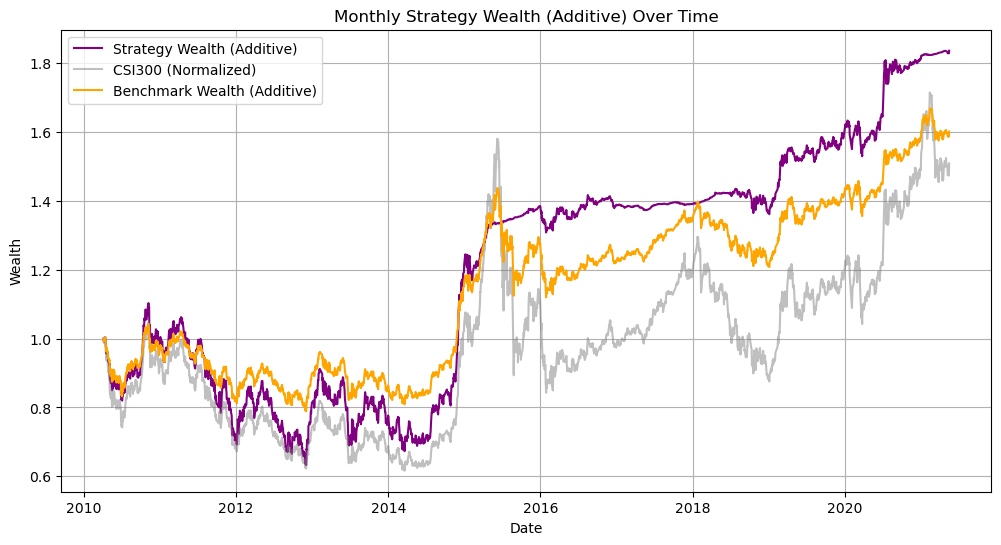

In [232]:
# plot wealth_add, csi300, and benchmark_add close against date 
plt.figure(figsize=(12,6))
plt.plot(feddata_monthly['date'], feddata_monthly['wealth_add'], label='Strategy Wealth (Additive)', color='purple')
plt.plot(feddata_monthly['date'].iloc[1215:], feddata_monthly['csi300'].iloc[1215:]/feddata_monthly['csi300'].iloc[1215], label='CSI300 (Normalized)', color='gray', alpha=0.5)
plt.plot(feddata_monthly['date'].iloc[1215:], feddata_monthly['benchmark_add'].iloc[1215:]/feddata_monthly['benchmark_add'].iloc[1215], label='Benchmark Wealth (Additive)', color='orange')
plt.plot()
plt.title('Monthly Strategy Wealth (Additive) Over Time')
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.legend()
plt.grid()
plt.show()


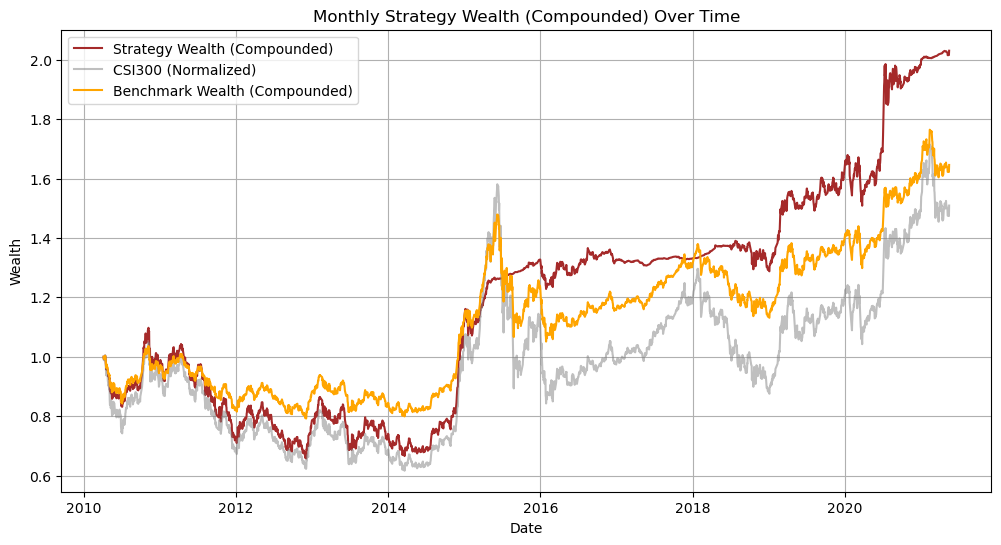

In [233]:
# plot wealth_comp, csi300, and benchmark close against date
plt.figure(figsize=(12,6))
plt.plot(feddata_monthly['date'], feddata_monthly['wealth_comp'], label='Strategy Wealth (Compounded)', color='brown')
plt.plot(feddata_monthly['date'].iloc[1215:], feddata_monthly['csi300'].iloc[1215:]/feddata_monthly['csi300'].iloc[1215], label='CSI300 (Normalized)', color='gray', alpha=0.5)
plt.plot(feddata_monthly['date'].iloc[1215:], feddata_monthly['benchmark_comp'].iloc[1215:]/feddata_monthly['benchmark_comp'].iloc[1215], label='Benchmark Wealth (Compounded)', color='orange')
plt.title('Monthly Strategy Wealth (Compounded) Over Time')
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.legend()
plt.grid()
plt.show()


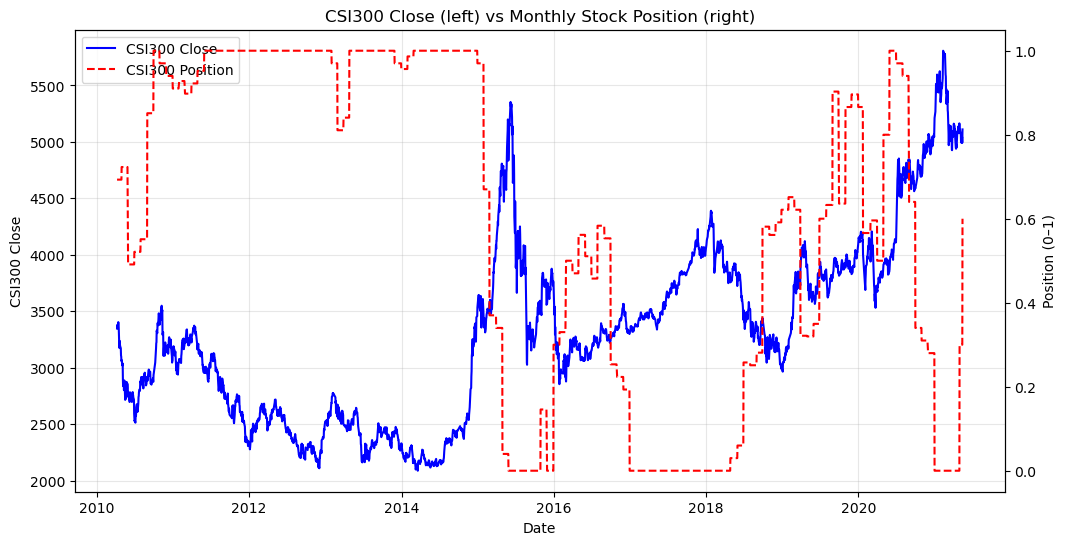

In [234]:
# plot stock position and csi300 close against date
# set csi300 close left y-axis and stock position right y-axis
# Left y-axis: CSI300 close
x = feddata_monthly['date'].iloc[1216:]
y_close = feddata_monthly['csi300'].iloc[1216:]
y_pos = feddata_monthly['csi300_position'].iloc[1216:]

fig, ax1 = plt.subplots(figsize=(12,6))

l1, = ax1.plot(x, y_close, label='CSI300 Close', linewidth=1.5, color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('CSI300 Close')
ax1.grid(True, alpha=0.3)

# Right y-axis: stock position
ax2 = ax1.twinx()
l2, = ax2.plot(x, y_pos, label='CSI300 Position', linestyle='--', linewidth=1.5, color='red')
ax2.set_ylabel('Position (0–1)')
ax2.set_ylim(-0.05, 1.05)

# One legend
lines = [l1, l2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('CSI300 Close (left) vs Monthly Stock Position (right)')
plt.show()

## Strategy 2: ALL Historcal Quantile Monthly

In [553]:
res_monthly2 = backtest_fed_model_monthly(feddata_monthly, colmap)
feddata_monthly  = res_monthly2.df
res_monthly2.stats

{'final_wealth_add': 1.9590843165814396,
 'final_wealth_comp': 2.243814934734918,
 'max_drawdown_add': -0.4060607887252595,
 'max_drawdown_comp': -0.3879645156137419,
 'mean_daily_ret': 0.0003553480239279138,
 'vol_daily_ret': 0.01056901057558628,
 'turnover_total': 15.733490004783793,
 'bench_final_comp': 1.6456863759446745,
 'bench_max_dd_comp': -0.2892526168289251,
 'bench_max_dd_add': -0.2429779845198622}

In [554]:
calculate_yearly_stats(feddata_monthly, wealth_col='wealth_comp', rf_rate=0.02, ann_factor=252)

,Year,AnnualReturn,AnnualVolatility,AnnualSharpe,MDDComp,Days,CAGR
0,2010,-0.021191,0.177325,-0.232290,-0.194397,180,NaN
1,2011,-0.248591,0.178377,-1.505752,-0.296715,244,NaN
2,2012,0.097531,0.200688,0.386324,-0.224054,243,NaN
3,2013,-0.077001,0.215943,-0.449199,-0.221594,238,NaN
4,2014,0.521702,0.189844,2.642715,-0.101212,245,NaN
5,2015,0.143839,0.163902,0.755569,-0.137353,244,NaN
6,2016,0.045054,0.112573,0.222562,-0.059771,244,NaN
7,2017,0.106906,0.054753,1.587224,-0.034831,244,NaN
8,2018,-0.119277,0.119933,-1.161287,-0.159188,243,NaN
9,2019,0.370210,0.159781,2.191809,-0.096049,244,NaN


In [497]:
feddata_monthly.columns

Index(['date', 'csi300', 'FED', 'CBA00201', 'bond_return', 'csi300_MA5',
       'csi300_MA40', 'csi300_vol_40', 'csi300_return', 'FED_quantile_5y',
       'csi300_vol_40_quantile_5y', 'FED_quantile', 'csi300_vol_40_quantile',
       'value_quantile', 'vol_quantile', 'value_score', 'vol_score',
       'equity_weight_target', 'csi300_position', 'bond_position',
       'equity_weight_prev', 'turnover', 'tx_cost', 'port_ret', 'wealth_comp',
       'wealth_add', 'drawdown_add', 'drawdown_comp', 'benchmark_add',
       'benchmark_comp', 'benchmark_drawdown_add', 'benchmark_drawdown_comp'],
      dtype='object')

In [555]:
feddata_monthly[['date','csi300', 'CBA00201','FED_quantile_5y','csi300_vol_40_quantile_5y','equity_weight_target',
       'csi300_position', 'bond_position', 'equity_weight_prev','port_ret','wealth_comp','wealth_add','drawdown_add','drawdown_comp','benchmark_add', 'benchmark_comp',
       'benchmark_drawdown_add', 'benchmark_drawdown_comp']].iloc[1212:1220]

,date,csi300,CBA00201,FED_quantile_5y,csi300_vol_40_quantile_5y,equity_weight_target,csi300_position,bond_position,equity_weight_prev,port_ret,wealth_comp,wealth_add,drawdown_add,drawdown_comp,benchmark_add,benchmark_comp,benchmark_drawdown_add,benchmark_drawdown_comp
1212,2010-04-01,3391.935,133.8733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1213,2010-04-02,3407.346,133.8779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1214,2010-04-06,3405.145,133.9253,NaN,0.283163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1215,2010-04-07,3386.949,133.8392,0.513980,0.282313,0.692902,0.692902,0.307098,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
1216,2010-04-08,3346.744,133.7631,0.526316,0.284014,0.700899,0.692902,0.307098,0.692902,-0.008400,0.991600,0.991600,-0.008400,-0.008400,0.992650,0.992650,-0.007350,-0.007350
1217,2010-04-09,3379.170,133.7676,0.526316,0.284864,0.699327,0.692902,0.307098,0.692902,0.006724,0.998268,0.998324,-0.001676,-0.001732,0.998477,0.998434,-0.001523,-0.001566
1218,2010-04-12,3351.478,133.8030,0.527961,0.279762,0.704068,0.692902,0.307098,0.692902,-0.005597,0.992680,0.992727,-0.007273,-0.007320,0.993666,0.993631,-0.006334,-0.006369
1219,2010-04-13,3391.716,133.8818,0.527961,0.276361,0.706024,0.692902,0.307098,0.692902,0.008500,1.001118,1.001227,0.000000,0.000000,1.001105,1.001022,0.000000,0.000000


In [556]:
# find the first few rows where the strategy starts
feddata_monthly[feddata_monthly['csi300_position']>0].head()

,date,csi300,FED,CBA00201,bond_return,csi300_MA5,csi300_MA40,csi300_vol_40,csi300_return,FED_quantile_5y,...,tx_cost,port_ret,wealth_comp,wealth_add,drawdown_add,drawdown_comp,benchmark_add,benchmark_comp,benchmark_drawdown_add,benchmark_drawdown_comp
1215,2010-04-07,3386.949,0.003791,133.8392,-0.000643,3387.3964,3274.130325,66.304469,-0.005344,0.513980,...,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
1216,2010-04-08,3346.744,0.004816,133.7631,-0.000569,3387.6238,3277.031050,66.891858,-0.011871,0.526316,...,0.0,-0.008400,0.991600,0.991600,-0.008400,-0.008400,0.992650,0.992650,-0.007350,-0.007350
1217,2010-04-09,3379.170,0.004610,133.7676,0.000034,3385.0708,3281.040250,68.107212,0.009689,0.526316,...,0.0,0.006724,0.998268,0.998324,-0.001676,-0.001732,0.998477,0.998434,-0.001523,-0.001566
1218,2010-04-12,3351.478,0.005096,133.8030,0.000265,3373.8972,3286.000025,65.732670,-0.008195,0.527961,...,0.0,-0.005597,0.992680,0.992727,-0.007273,-0.007320,0.993666,0.993631,-0.006334,-0.006369
1219,2010-04-13,3391.716,0.005049,133.8818,0.000589,3371.2114,3292.018225,64.053151,0.012006,0.527961,...,0.0,0.008500,1.001118,1.001227,0.000000,0.000000,1.001105,1.001022,0.000000,0.000000


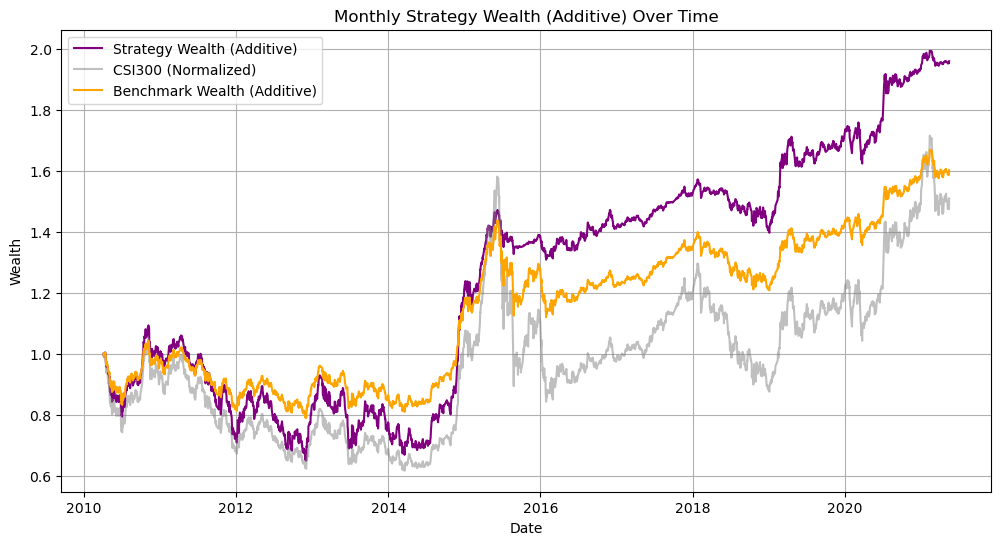

In [557]:
# plot wealth_add, csi300, and benchmark_add close against date 
plt.figure(figsize=(12,6))
plt.plot(feddata_monthly['date'], feddata_monthly['wealth_add'], label='Strategy Wealth (Additive)', color='purple')
plt.plot(feddata_monthly['date'].iloc[1215:], feddata_monthly['csi300'].iloc[1215:]/feddata_monthly['csi300'].iloc[1215], label='CSI300 (Normalized)', color='gray', alpha=0.5)
plt.plot(feddata_monthly['date'].iloc[1215:], feddata_monthly['benchmark_add'].iloc[1215:]/feddata_monthly['benchmark_add'].iloc[1215], label='Benchmark Wealth (Additive)', color='orange')
plt.plot()
plt.title('Monthly Strategy Wealth (Additive) Over Time')
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.legend()
plt.grid()
plt.show()


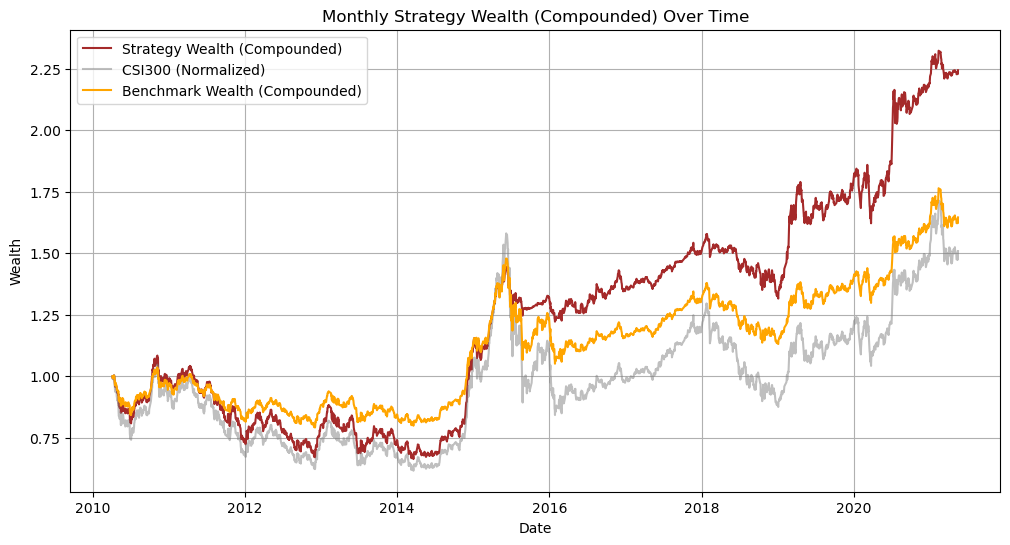

In [558]:
# plot wealth_comp, csi300, and benchmark close against date
plt.figure(figsize=(12,6))
plt.plot(feddata_monthly['date'], feddata_monthly['wealth_comp'], label='Strategy Wealth (Compounded)', color='brown')
plt.plot(feddata_monthly['date'].iloc[1215:], feddata_monthly['csi300'].iloc[1215:]/feddata_monthly['csi300'].iloc[1215], label='CSI300 (Normalized)', color='gray', alpha=0.5)
plt.plot(feddata_monthly['date'].iloc[1215:], feddata_monthly['benchmark_comp'].iloc[1215:]/feddata_monthly['benchmark_comp'].iloc[1215], label='Benchmark Wealth (Compounded)', color='orange')
plt.title('Monthly Strategy Wealth (Compounded) Over Time')
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.legend()
plt.grid()
plt.show()


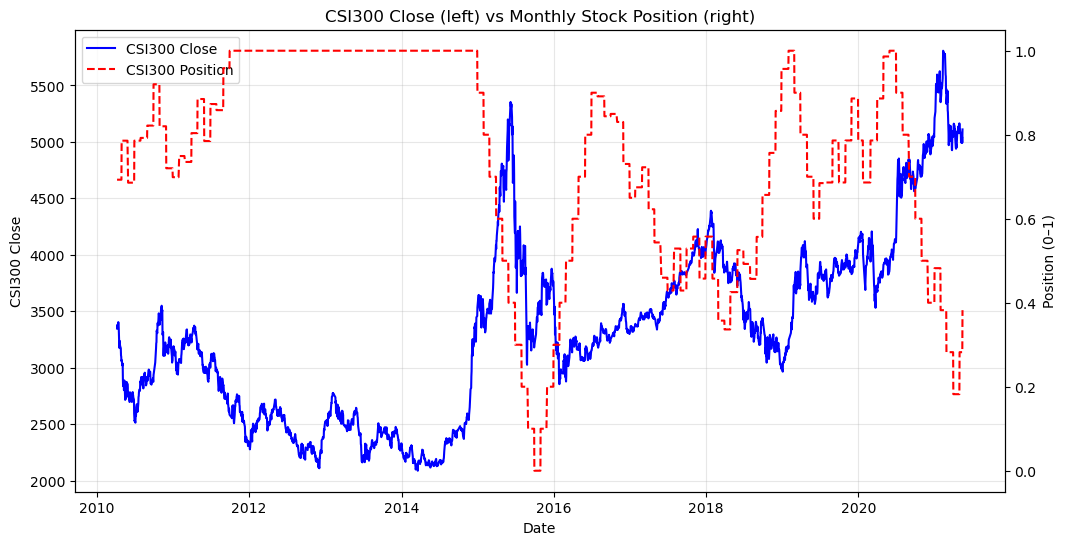

In [559]:
# plot stock position and csi300 close against date
# set csi300 close left y-axis and stock position right y-axis
# Left y-axis: CSI300 close
x = feddata_monthly['date'].iloc[1216:]
y_close = feddata_monthly['csi300'].iloc[1216:]
y_pos = feddata_monthly['csi300_position'].iloc[1216:]

fig, ax1 = plt.subplots(figsize=(12,6))

l1, = ax1.plot(x, y_close, label='CSI300 Close', linewidth=1.5, color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('CSI300 Close')
ax1.grid(True, alpha=0.3)

# Right y-axis: stock position
ax2 = ax1.twinx()
l2, = ax2.plot(x, y_pos, label='CSI300 Position', linestyle='--', linewidth=1.5, color='red')
ax2.set_ylabel('Position (0–1)')
ax2.set_ylim(-0.05, 1.05)

# One legend
lines = [l1, l2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('CSI300 Close (left) vs Monthly Stock Position (right)')
plt.show()

# Strategy 3 (Combine Trend: 40 MA)

Case 1: Strong Up Trend
1. if current stock position < previous stock position 
2. fed value < previous fed value (relative value has increases)
3. stock close price > 40 MA \
Set turnover rate 3%

Case 2: Strong Down Trend
1. if current stock position > previous stock postion
2. fed value > previous fed value (relative value has decreases)
3. stock close price < 40 MA \
Set turnover rate 3%

Case 3: Others\
Set turnover rate 30%

## Strategy3: 5 Year Quantile Monthly

In [504]:
feddata_monthly2

,date,csi300,FED,CBA00201,bond_return,csi300_MA5,csi300_MA40,csi300_vol_40,csi300_return,FED_quantile_5y,csi300_vol_40_quantile_5y,FED_quantile,csi300_vol_40_quantile
0,2005-04-08,1003.4450,0.020882,109.2280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
1,2005-04-11,995.4210,0.022335,109.3790,0.001382,NaN,NaN,NaN,-0.007996,NaN,NaN,1.000000,NaN
2,2005-04-12,978.6970,0.025016,109.3810,0.000018,NaN,NaN,NaN,-0.016801,NaN,NaN,1.000000,NaN
3,2005-04-13,1000.9000,0.021253,109.5350,0.001408,NaN,NaN,NaN,0.022686,NaN,NaN,0.500000,NaN
4,2005-04-14,986.9750,0.023021,109.7920,0.002346,993.08760,NaN,NaN,-0.013912,NaN,NaN,0.800000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3909,2021-05-10,4992.4220,0.037398,210.3841,0.000309,5067.45146,5058.935843,68.645930,-0.000727,0.449013,0.316327,0.541688,0.319943
3910,2021-05-11,5023.0595,0.037126,210.4895,0.000501,5039.22952,5059.422027,68.312109,0.006137,0.442434,0.313776,0.537203,0.318569
3911,2021-05-12,5044.5481,0.036673,210.5644,0.000356,5023.44134,5057.330340,67.426864,0.004278,0.436678,0.305272,0.531953,0.309708
3912,2021-05-13,4992.9738,0.037301,210.5400,-0.000116,5009.81122,5053.495220,66.589586,-0.010224,0.447368,0.298469,0.540250,0.301368


In [570]:
res_monthly3 = backtest_fed_model_monthly_tri(feddata_monthly2)
feddata_monthly3  = res_monthly3.df
res_monthly3.stats

{'final_wealth_add': 1.8362025422503172,
 'final_wealth_comp': 2.0303229811041783,
 'max_drawdown_add': -0.4265763558090333,
 'max_drawdown_comp': -0.4011846460327899,
 'mean_daily_ret': 0.0003098193932013028,
 'vol_daily_ret': 0.009733046820385349,
 'turnover_total': 17.809156149301828,
 'bench_final_add': 1.601421986044806,
 'bench_final_comp': 1.6456863759446745,
 'bench_max_dd_add': -0.2429779845198622,
 'bench_max_dd_comp': -0.2892526168289251}

In [571]:
calculate_yearly_stats(feddata_monthly3, wealth_col='wealth_comp', rf_rate=0.00, ann_factor=252)

,Year,AnnualReturn,AnnualVolatility,AnnualSharpe,MDDComp,Days,CAGR
0,2010,-0.028483,0.176902,-0.161009,-0.171627,180,NaN
1,2011,-0.260814,0.197624,-1.319751,-0.311231,244,NaN
2,2012,0.097531,0.200688,0.485981,-0.224054,243,NaN
3,2013,-0.058575,0.207978,-0.281642,-0.206309,238,NaN
4,2014,0.526562,0.189100,2.784573,-0.098403,245,NaN
5,2015,0.143738,0.116470,1.234125,-0.077302,244,NaN
6,2016,0.022413,0.085374,0.262523,-0.059468,244,NaN
7,2017,0.002509,0.009904,0.253383,-0.015731,244,NaN
8,2018,-0.024908,0.079165,-0.314627,-0.070524,243,NaN
9,2019,0.274019,0.111173,2.464789,-0.047679,244,NaN


In [507]:
feddata_monthly3.columns

Index(['date', 'csi300', 'FED', 'CBA00201', 'bond_return', 'csi300_MA5',
       'csi300_MA40', 'csi300_vol_40', 'csi300_return', 'FED_quantile_5y',
       'csi300_vol_40_quantile_5y', 'FED_quantile', 'csi300_vol_40_quantile',
       'value_quantile', 'vol_quantile', 'value_score', 'vol_score',
       'equity_weight_target', 'csi300_position', 'bond_position',
       'equity_weight_prev', 'turnover', 'tx_cost', 'port_ret', 'wealth_add',
       'wealth_comp', 'drawdown_add', 'drawdown_comp', 'cum_max_benchmark_add',
       'cum_max_benchmark_comp', 'benchmark_ret', 'benchmark_add',
       'benchmark_comp', 'benchmark_drawdown_add', 'benchmark_drawdown_comp',
       'trend_cap', 'is_uptrend', 'is_downtrend', 'prev_month_target'],
      dtype='object')

In [508]:
feddata_monthly3[['date','csi300', 'CBA00201','FED_quantile_5y','csi300_vol_40_quantile_5y','equity_weight_target',
       'csi300_position', 'bond_position', 'equity_weight_prev','port_ret','wealth_comp','wealth_add','drawdown_add','drawdown_comp','benchmark_ret','benchmark_add', 'benchmark_comp',
       'benchmark_drawdown_add', 'benchmark_drawdown_comp']].iloc[1212:1220]

,date,csi300,CBA00201,FED_quantile_5y,csi300_vol_40_quantile_5y,equity_weight_target,csi300_position,bond_position,equity_weight_prev,port_ret,wealth_comp,wealth_add,drawdown_add,drawdown_comp,benchmark_ret,benchmark_add,benchmark_comp,benchmark_drawdown_add,benchmark_drawdown_comp
1212,2010-04-01,3391.935,133.8733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1213,2010-04-02,3407.346,133.8779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1214,2010-04-06,3405.145,133.9253,NaN,0.283163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1215,2010-04-07,3386.949,133.8392,0.513980,0.282313,0.693056,0.693056,0.306944,0.693056,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
1216,2010-04-08,3346.744,133.7631,0.526316,0.284014,0.701918,0.693056,0.306944,0.693056,-0.008401,0.991599,0.991599,-0.008401,-0.008401,-0.007350,0.992650,0.992650,-0.007350,-0.007350
1217,2010-04-09,3379.170,133.7676,0.526316,0.284864,0.701210,0.693056,0.306944,0.693056,0.006725,0.998267,0.998324,-0.001676,-0.001733,0.005827,0.998477,0.998434,-0.001523,-0.001566
1218,2010-04-12,3351.478,133.8030,0.527961,0.279762,0.706832,0.693056,0.306944,0.693056,-0.005598,0.992679,0.992725,-0.007275,-0.007321,-0.004811,0.993666,0.993631,-0.006334,-0.006369
1219,2010-04-13,3391.716,133.8818,0.527961,0.276361,0.709667,0.693056,0.306944,0.693056,0.008502,1.001118,1.001227,0.000000,0.000000,0.007439,1.001105,1.001022,0.000000,0.000000


In [227]:
# mannual check of the first row
0.6*(3346.744-3386.949)/3386.949 + 0.4*(133.7631-133.8392)/133.8392

-0.007349776412546658

In [509]:
feddata_monthly3[['date','csi300', 'CBA00201','FED_quantile_5y','csi300_vol_40_quantile_5y','equity_weight_target',
       'csi300_position', 'bond_position', 'equity_weight_prev','port_ret','wealth_comp','wealth_add','drawdown_add','drawdown_comp','benchmark_ret','benchmark_add', 'benchmark_comp',
       'benchmark_drawdown_add', 'benchmark_drawdown_comp']].iloc[1220:1240]

,date,csi300,CBA00201,FED_quantile_5y,csi300_vol_40_quantile_5y,equity_weight_target,csi300_position,bond_position,equity_weight_prev,port_ret,wealth_comp,wealth_add,drawdown_add,drawdown_comp,benchmark_ret,benchmark_add,benchmark_comp,benchmark_drawdown_add,benchmark_drawdown_comp
1220,2010-04-14,3403.707,133.9038,0.530428,0.274660,0.713140,0.693056,0.306944,0.693056,0.002501,1.003621,1.003728,0.000000,0.000000,0.002187,1.003292,1.003212,0.000000,0.000000
1221,2010-04-15,3394.574,133.9387,0.532072,0.274660,0.714510,0.693056,0.306944,0.693056,-0.001780,1.001835,1.001948,-0.001773,-0.001780,-0.001506,1.001786,1.001701,-0.001501,-0.001506
1222,2010-04-16,3356.332,133.9689,0.533717,0.272959,0.717298,0.693056,0.306944,0.693056,-0.007739,0.994083,0.994210,-0.009483,-0.009504,-0.006669,0.995117,0.995021,-0.008148,-0.008165
1223,2010-04-19,3176.423,134.0944,0.551809,0.278912,0.727415,0.693056,0.306944,0.693056,-0.036862,0.957439,0.957347,-0.046208,-0.046016,-0.031787,0.963330,0.963392,-0.039831,-0.039692
1224,2010-04-20,3173.374,134.1697,0.557566,0.284014,0.727960,0.693056,0.306944,0.693056,-0.000493,0.956967,0.956854,-0.046699,-0.046486,-0.000351,0.962979,0.963053,-0.040181,-0.040030
1225,2010-04-21,3236.679,134.2096,0.556743,0.279762,0.730818,0.693056,0.306944,0.693056,0.013917,0.970285,0.970771,-0.032834,-0.033217,0.012088,0.975067,0.974695,-0.028132,-0.028425
1226,2010-04-22,3201.541,134.2554,0.568257,0.284014,0.736869,0.693056,0.306944,0.693056,-0.007419,0.963086,0.963352,-0.040226,-0.040389,-0.006377,0.968690,0.968479,-0.034489,-0.034621
1227,2010-04-23,3190.003,134.3326,0.592928,0.285714,0.756011,0.693056,0.306944,0.693056,-0.002321,0.960850,0.961031,-0.042538,-0.042617,-0.001932,0.966758,0.966608,-0.036415,-0.036487
1228,2010-04-26,3171.997,134.4610,0.620888,0.288265,0.777186,0.693056,0.306944,0.693056,-0.003619,0.957373,0.957412,-0.046143,-0.046081,-0.003004,0.963753,0.963704,-0.039409,-0.039381
1229,2010-04-27,3108.409,134.4988,0.644737,0.296769,0.789973,0.693056,0.306944,0.693056,-0.013807,0.944155,0.943605,-0.059899,-0.059252,-0.011916,0.951838,0.952221,-0.051286,-0.050828


In [ ]:
# mannual check of the first position change
0.693056*(3067.365-3060.064)/3060.064 + 0.30694*(134.6197-134.5925	)/134.5925	-abs(0.693056-0.723056)*2*0.0005

0.0016855907580222535

In [511]:
# find the first few rows where the strategy starts
feddata_monthly3[feddata_monthly3['csi300_position']>0].head()

,date,csi300,FED,CBA00201,bond_return,csi300_MA5,csi300_MA40,csi300_vol_40,csi300_return,FED_quantile_5y,...,cum_max_benchmark_comp,benchmark_ret,benchmark_add,benchmark_comp,benchmark_drawdown_add,benchmark_drawdown_comp,trend_cap,is_uptrend,is_downtrend,prev_month_target
1215,2010-04-07,3386.949,0.003791,133.8392,-0.000643,3387.3964,3274.130325,66.304469,-0.005344,0.513980,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,NaN,False,False,NaN
1216,2010-04-08,3346.744,0.004816,133.7631,-0.000569,3387.6238,3277.031050,66.891858,-0.011871,0.526316,...,1.000000,-0.007350,0.992650,0.992650,-0.007350,-0.007350,NaN,False,False,NaN
1217,2010-04-09,3379.170,0.004610,133.7676,0.000034,3385.0708,3281.040250,68.107212,0.009689,0.526316,...,1.000000,0.005827,0.998477,0.998434,-0.001523,-0.001566,NaN,False,False,NaN
1218,2010-04-12,3351.478,0.005096,133.8030,0.000265,3373.8972,3286.000025,65.732670,-0.008195,0.527961,...,1.000000,-0.004811,0.993666,0.993631,-0.006334,-0.006369,NaN,False,False,NaN
1219,2010-04-13,3391.716,0.005049,133.8818,0.000589,3371.2114,3292.018225,64.053151,0.012006,0.527961,...,1.001022,0.007439,1.001105,1.001022,0.000000,0.000000,NaN,False,False,NaN


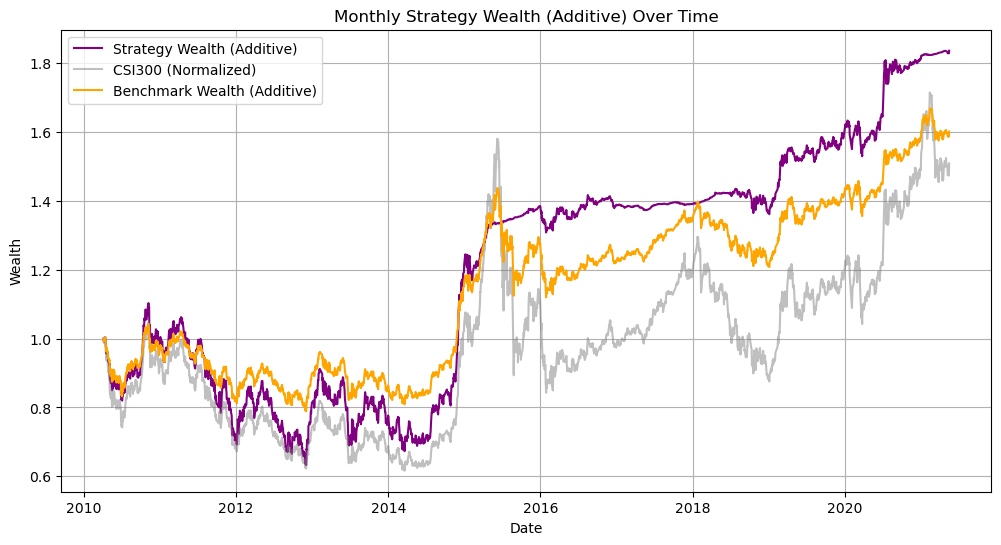

In [513]:
# plot wealth_add, csi300, and benchmark_add close against date 
plt.figure(figsize=(12,6))
plt.plot(feddata_monthly3['date'], feddata_monthly3['wealth_add'], label='Strategy Wealth (Additive)', color='purple')
plt.plot(feddata_monthly3['date'].iloc[1215:], feddata_monthly3['csi300'].iloc[1215:]/feddata_monthly3['csi300'].iloc[1215], label='CSI300 (Normalized)', color='gray', alpha=0.5)
plt.plot(feddata_monthly3['date'].iloc[1215:], feddata_monthly3['benchmark_add'].iloc[1215:]/feddata_monthly3['benchmark_add'].iloc[1215], label='Benchmark Wealth (Additive)', color='orange')
plt.plot()
plt.title('Monthly Strategy Wealth (Additive) Over Time')
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.legend()
plt.grid()
plt.show()


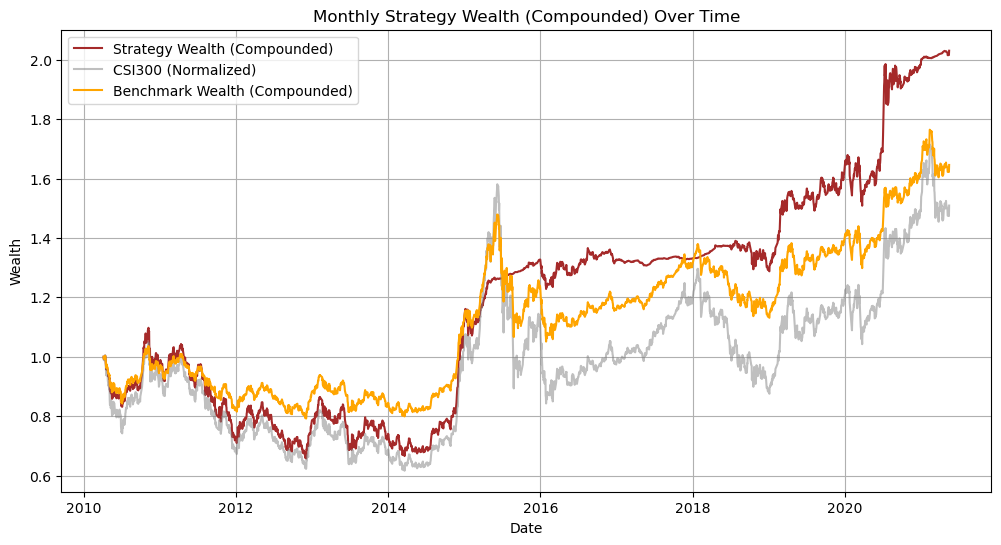

In [514]:
# plot wealth_comp, csi300, and benchmark close against date
plt.figure(figsize=(12,6))
plt.plot(feddata_monthly3['date'], feddata_monthly3['wealth_comp'], label='Strategy Wealth (Compounded)', color='brown')
plt.plot(feddata_monthly3['date'].iloc[1215:], feddata_monthly3['csi300'].iloc[1215:]/feddata_monthly3['csi300'].iloc[1215], label='CSI300 (Normalized)', color='gray', alpha=0.5)
plt.plot(feddata_monthly3['date'].iloc[1215:], feddata_monthly3['benchmark_comp'].iloc[1215:]/feddata_monthly3['benchmark_comp'].iloc[1215], label='Benchmark Wealth (Compounded)', color='orange')
plt.title('Monthly Strategy Wealth (Compounded) Over Time')
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.legend()
plt.grid()
plt.show()


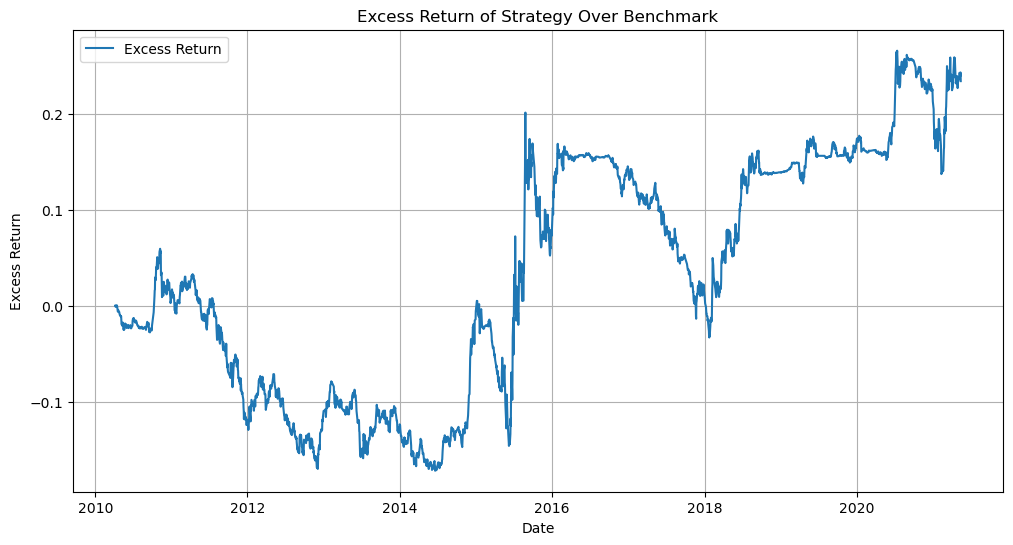

In [515]:
# calculate the excess return of the strategy over the benchmark
excess_return = feddata_monthly3['wealth_comp'] / feddata_monthly3['benchmark_comp'] - 1.0
plt.figure(figsize=(12,6))
plt.plot(feddata_monthly3['date'].iloc[1215:], excess_return.iloc[1215:], label='Excess Return')
plt.title('Excess Return of Strategy Over Benchmark')       
plt.xlabel('Date')
plt.ylabel('Excess Return')
plt.legend()
plt.grid()
plt.show()

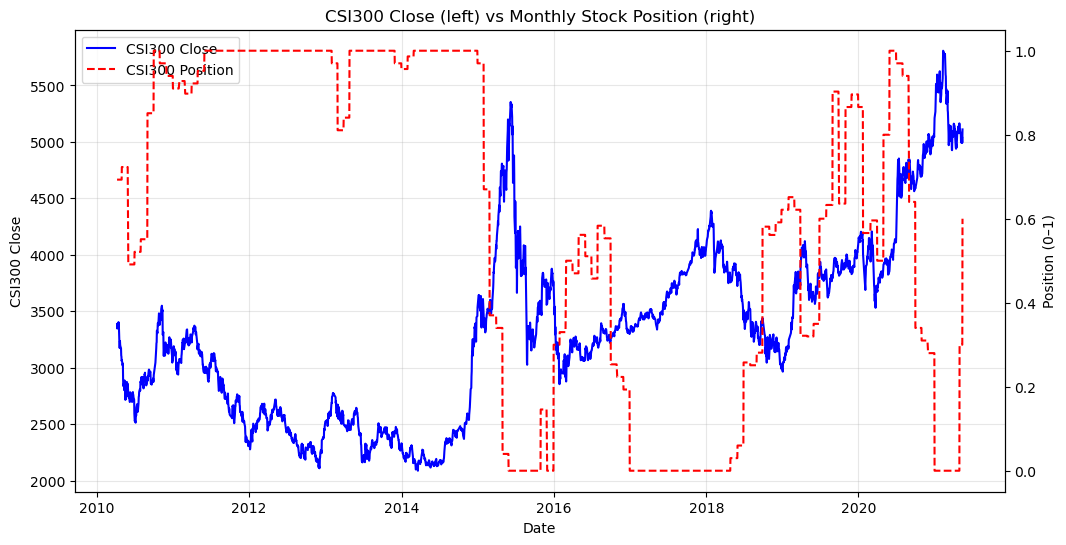

In [516]:
# plot stock position and csi300 close against date
# set csi300 close left y-axis and stock position right y-axis
# Left y-axis: CSI300 close
x = feddata_monthly3['date'].iloc[1215:]
y_close = feddata_monthly3['csi300'].iloc[1215:]
y_pos = feddata_monthly3['csi300_position'].iloc[1215:]

fig, ax1 = plt.subplots(figsize=(12,6))

l1, = ax1.plot(x, y_close, label='CSI300 Close', linewidth=1.5, color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('CSI300 Close')
ax1.grid(True, alpha=0.3)

# Right y-axis: stock position
ax2 = ax1.twinx()
l2, = ax2.plot(x, y_pos, label='CSI300 Position', linestyle='--', linewidth=1.5, color='red')
ax2.set_ylabel('Position (0–1)')
ax2.set_ylim(-0.05, 1.05)

# One legend
lines = [l1, l2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')

plt.title('CSI300 Close (left) vs Monthly Stock Position (right)')
plt.show()

## Strategy 3: ALL Historcal Quantile Monthly

In [560]:
colmap = {
            'stock_ret': 'csi300_return',
            'bond_ret': 'bond_return',
            'value_quantile': 'FED_quantile',
            'vol_quantile': 'csi300_vol_40_quantile',
            'close': 'csi300',
            'fed_value': 'FED',   # if missing, we will fallback to value_quantile
            'ma40': 'csi300_MA40',  # optional, if not present we will calculate it
        }

In [572]:
res_monthly3 = backtest_fed_model_monthly_tri(feddata_monthly2, colmap)
feddata_monthly3  = res_monthly3.df
res_monthly3.stats

{'final_wealth_add': 1.9736593747036335,
 'final_wealth_comp': 2.275202657514245,
 'max_drawdown_add': -0.409279237528801,
 'max_drawdown_comp': -0.3889169790615795,
 'mean_daily_ret': 0.0003607481936656666,
 'vol_daily_ret': 0.01058931080150483,
 'turnover_total': 19.286397795993537,
 'bench_final_add': 1.601421986044806,
 'bench_final_comp': 1.6456863759446745,
 'bench_max_dd_add': -0.2429779845198622,
 'bench_max_dd_comp': -0.2892526168289251}

In [573]:
calculate_yearly_stats(feddata_monthly3, wealth_col='wealth_comp', rf_rate=0.00, ann_factor=252)

,Year,AnnualReturn,AnnualVolatility,AnnualSharpe,MDDComp,Days,CAGR
0,2010,-0.034758,0.167787,-0.207158,-0.170471,180,NaN
1,2011,-0.244403,0.178390,-1.370047,-0.289465,244,NaN
2,2012,0.097531,0.200688,0.485981,-0.224054,243,NaN
3,2013,-0.077001,0.215943,-0.356582,-0.221594,238,NaN
4,2014,0.521807,0.189851,2.748506,-0.101212,245,NaN
5,2015,0.252992,0.135724,1.864029,-0.077302,244,NaN
6,2016,-0.033696,0.155834,-0.216229,-0.141110,244,NaN
7,2017,0.117134,0.056192,2.084540,-0.034257,244,NaN
8,2018,-0.149772,0.133201,-1.124406,-0.189034,243,NaN
9,2019,0.392551,0.153826,2.551922,-0.069157,244,NaN


In [563]:
# find the first few rows where the strategy starts
feddata_monthly3[feddata_monthly3['csi300_position']>0].head()

,date,csi300,FED,CBA00201,bond_return,csi300_MA5,csi300_MA40,csi300_vol_40,csi300_return,FED_quantile_5y,...,cum_max_benchmark_comp,benchmark_ret,benchmark_add,benchmark_comp,benchmark_drawdown_add,benchmark_drawdown_comp,trend_cap,is_uptrend,is_downtrend,prev_month_target
1215,2010-04-07,3386.949,0.003791,133.8392,-0.000643,3387.3964,3274.130325,66.304469,-0.005344,0.513980,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,NaN,False,False,NaN
1216,2010-04-08,3346.744,0.004816,133.7631,-0.000569,3387.6238,3277.031050,66.891858,-0.011871,0.526316,...,1.000000,-0.007350,0.992650,0.992650,-0.007350,-0.007350,NaN,False,False,NaN
1217,2010-04-09,3379.170,0.004610,133.7676,0.000034,3385.0708,3281.040250,68.107212,0.009689,0.526316,...,1.000000,0.005827,0.998477,0.998434,-0.001523,-0.001566,NaN,False,False,NaN
1218,2010-04-12,3351.478,0.005096,133.8030,0.000265,3373.8972,3286.000025,65.732670,-0.008195,0.527961,...,1.000000,-0.004811,0.993666,0.993631,-0.006334,-0.006369,NaN,False,False,NaN
1219,2010-04-13,3391.716,0.005049,133.8818,0.000589,3371.2114,3292.018225,64.053151,0.012006,0.527961,...,1.001022,0.007439,1.001105,1.001022,0.000000,0.000000,NaN,False,False,NaN


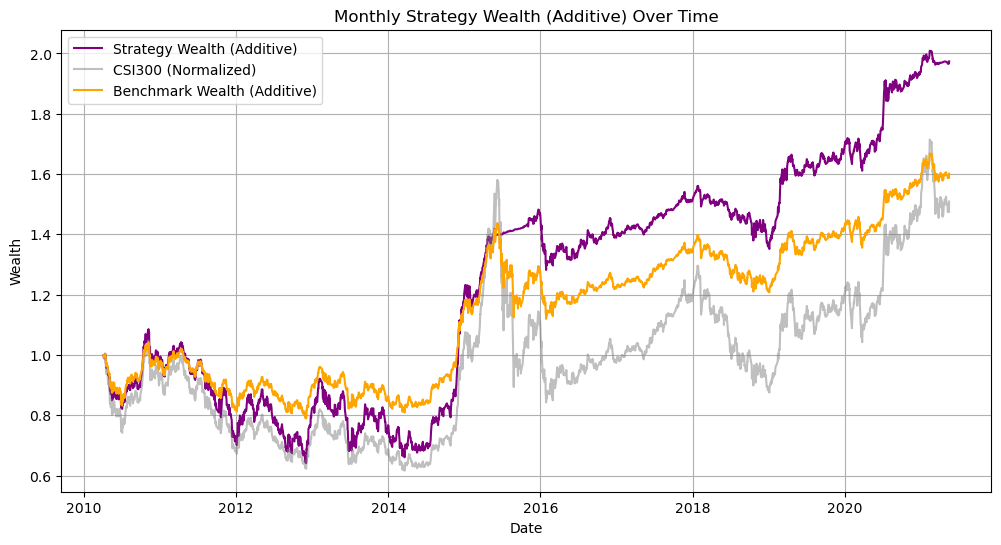

In [564]:
# plot wealth_add, csi300, and benchmark_add close against date 
plt.figure(figsize=(12,6))
plt.plot(feddata_monthly3['date'], feddata_monthly3['wealth_add'], label='Strategy Wealth (Additive)', color='purple')
plt.plot(feddata_monthly3['date'].iloc[1215:], feddata_monthly3['csi300'].iloc[1215:]/feddata_monthly3['csi300'].iloc[1215], label='CSI300 (Normalized)', color='gray', alpha=0.5)
plt.plot(feddata_monthly3['date'].iloc[1215:], feddata_monthly3['benchmark_add'].iloc[1215:]/feddata_monthly3['benchmark_add'].iloc[1215], label='Benchmark Wealth (Additive)', color='orange')
plt.plot()
plt.title('Monthly Strategy Wealth (Additive) Over Time')
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.legend()
plt.grid()
plt.show()


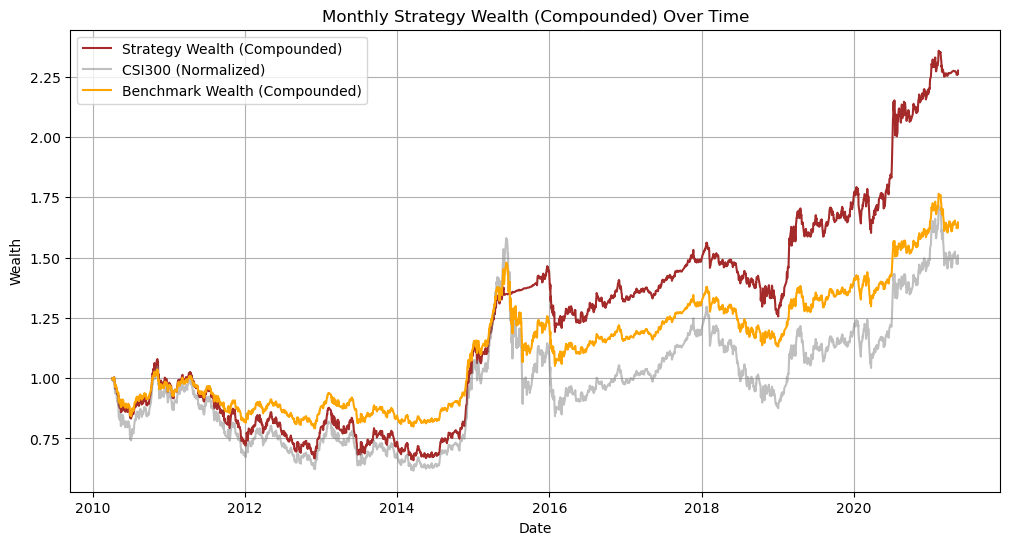

In [565]:
# plot wealth_comp, csi300, and benchmark close against date
plt.figure(figsize=(12,6))
plt.plot(feddata_monthly3['date'], feddata_monthly3['wealth_comp'], label='Strategy Wealth (Compounded)', color='brown')
plt.plot(feddata_monthly3['date'].iloc[1215:], feddata_monthly3['csi300'].iloc[1215:]/feddata_monthly3['csi300'].iloc[1215], label='CSI300 (Normalized)', color='gray', alpha=0.5)
plt.plot(feddata_monthly3['date'].iloc[1215:], feddata_monthly3['benchmark_comp'].iloc[1215:]/feddata_monthly3['benchmark_comp'].iloc[1215], label='Benchmark Wealth (Compounded)', color='orange')
plt.title('Monthly Strategy Wealth (Compounded) Over Time')
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.legend()
plt.grid()
plt.show()


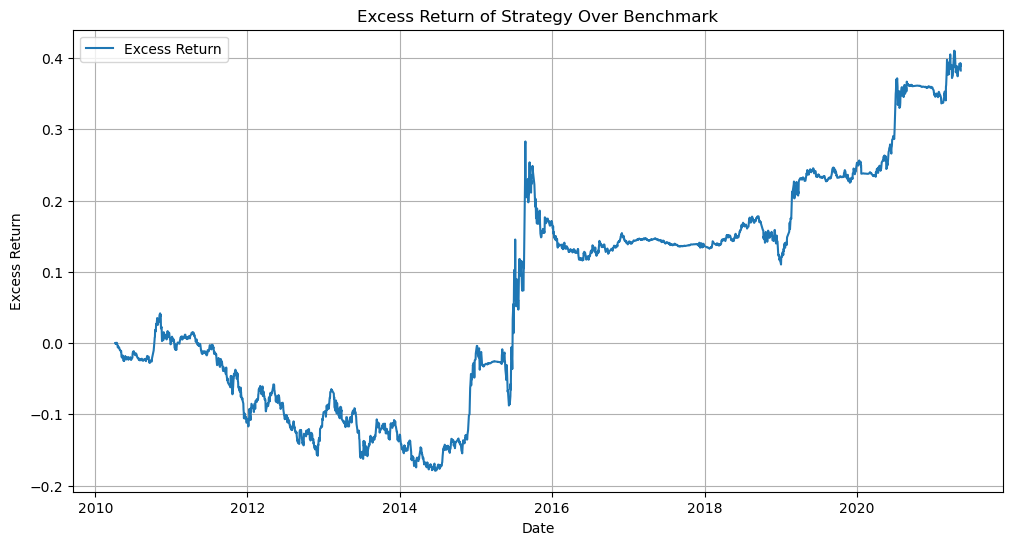

In [567]:
# calculate the excess return of the strategy over the benchmark
excess_return = feddata_monthly3['wealth_comp'] / feddata_monthly3['benchmark_comp'] - 1.0
plt.figure(figsize=(12,6))
plt.plot(feddata_monthly3['date'], excess_return, label='Excess Return')
plt.title('Excess Return of Strategy Over Benchmark')       
plt.xlabel('Date')
plt.ylabel('Excess Return')
plt.legend()
plt.grid()
plt.show()

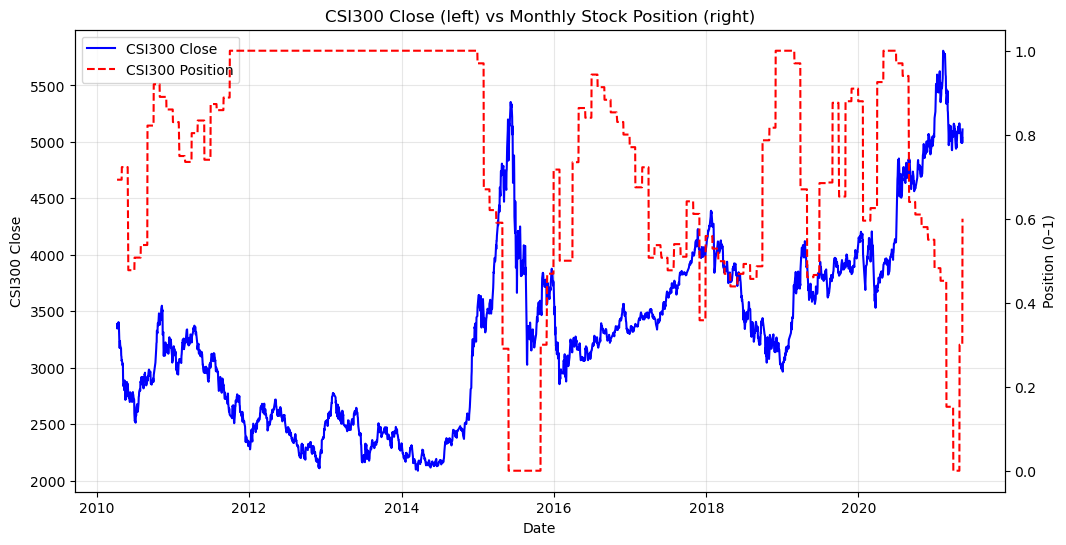

In [568]:
# plot stock position and csi300 close against date
# set csi300 close left y-axis and stock position right y-axis
# Left y-axis: CSI300 close
x = feddata_monthly3['date'].iloc[1215:]
y_close = feddata_monthly3['csi300'].iloc[1215:]
y_pos = feddata_monthly3['csi300_position'].iloc[1215:]

fig, ax1 = plt.subplots(figsize=(12,6))

l1, = ax1.plot(x, y_close, label='CSI300 Close', linewidth=1.5, color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('CSI300 Close')
ax1.grid(True, alpha=0.3)

# Right y-axis: stock position
ax2 = ax1.twinx()
l2, = ax2.plot(x, y_pos, label='CSI300 Position', linestyle='--', linewidth=1.5, color='red')
ax2.set_ylabel('Position (0–1)')
ax2.set_ylim(-0.05, 1.05)

# One legend
lines = [l1, l2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')

plt.title('CSI300 Close (left) vs Monthly Stock Position (right)')
plt.show()

# Comparison with CSI300 and Benchmark

In [574]:
perf_strategy = calculate_yearly_stats(feddata_monthly3, wealth_col='wealth_comp', rf_rate=0.03, ann_factor=252)
perf_strategy

,Year,AnnualReturn,AnnualVolatility,AnnualSharpe,MDDComp,Days,CAGR
0,2010,-0.034758,0.167787,-0.385956,-0.170471,180,NaN
1,2011,-0.244403,0.178390,-1.538218,-0.289465,244,NaN
2,2012,0.097531,0.200688,0.336496,-0.224054,243,NaN
3,2013,-0.077001,0.215943,-0.495507,-0.221594,238,NaN
4,2014,0.521807,0.189851,2.590487,-0.101212,245,NaN
5,2015,0.252992,0.135724,1.642991,-0.077302,244,NaN
6,2016,-0.033696,0.155834,-0.408742,-0.141110,244,NaN
7,2017,0.117134,0.056192,1.550655,-0.034257,244,NaN
8,2018,-0.149772,0.133201,-1.349630,-0.189034,243,NaN
9,2019,0.392551,0.153826,2.356896,-0.069157,244,NaN


In [581]:
# csi300 stats
perf_csi300 = calculate_yearly_stats(feddata_monthly3.iloc[1215:], wealth_col='csi300', rf_rate=0.03, ann_factor=252)
perf_csi300

,Year,AnnualReturn,AnnualVolatility,AnnualSharpe,MDDComp,Days,CAGR
0,2010,-0.076378,0.224951,-0.472894,-0.261790,180,NaN
1,2011,-0.264584,0.203331,-1.448796,-0.316425,244,NaN
2,2012,0.097531,0.200688,0.336496,-0.224054,243,NaN
3,2013,-0.077001,0.215943,-0.495507,-0.221594,238,NaN
4,2014,0.521851,0.189854,2.590679,-0.101212,245,NaN
5,2015,0.024568,0.387946,-0.014003,-0.434846,244,NaN
6,2016,-0.045829,0.218683,-0.346756,-0.193811,244,NaN
7,2017,0.206039,0.099842,1.763168,-0.060675,244,NaN
8,2018,-0.263431,0.210383,-1.394748,-0.318774,243,NaN
9,2019,0.379536,0.195362,1.789177,-0.134915,244,NaN


In [582]:
# benchmark stats
perf_benchmark = calculate_yearly_stats(feddata_monthly3, wealth_col='benchmark_comp', rf_rate=0.03, ann_factor=252)
perf_benchmark

,Year,AnnualReturn,AnnualVolatility,AnnualSharpe,MDDComp,Days,CAGR
0,2010,-0.039299,0.135017,-0.513257,-0.160386,180,NaN
1,2011,-0.147231,0.122043,-1.452206,-0.187739,244,NaN
2,2012,0.077524,0.120070,0.395804,-0.131786,243,NaN
3,2013,-0.043344,0.130112,-0.563699,-0.132591,238,NaN
4,2014,0.344147,0.114165,2.751704,-0.055867,245,NaN
5,2015,0.065978,0.232688,0.154618,-0.278860,244,NaN
6,2016,-0.015168,0.131829,-0.342628,-0.118676,244,NaN
7,2017,0.121418,0.060431,1.512763,-0.035738,244,NaN
8,2018,-0.136515,0.125549,-1.326295,-0.177136,243,NaN
9,2019,0.239860,0.116315,1.804246,-0.078743,244,NaN


In [579]:


def compare_from_yearly_tables(
    tables: dict[str, pd.DataFrame] | None = None,
    *,  # force keyword-only
    strategy_df: pd.DataFrame | None = None,
    benchmark_df: pd.DataFrame | None = None,
    csi300_df: pd.DataFrame | None = None,
):
    """
    Compare performance using outputs like calculate_yearly_stats(...).
    You can either pass a dict: {label -> yearly_table} OR pass the three DFs.

    Each table must contain columns:
      ['Year','AnnualReturn','AnnualVolatility','AnnualSharpe','MDDComp']
    and optionally 'CAGR'. The 'Year' column includes the string 'Overall'.

    Returns
    -------
    yearly_returns_wide : DataFrame
        Index = calendar year (int). Columns = labels. Values = AnnualReturn.
    overall_summary     : DataFrame
        One row per label with Overall metrics: Return, Volatility, Sharpe, MDD, CAGR.
    """
    # --- normalize inputs to a dict[label -> df] ---
    if tables is None:
        tables = {}
        if strategy_df is not None:  tables["Strategy"]  = strategy_df.copy()
        if benchmark_df is not None: tables["Benchmark"] = benchmark_df.copy()
        if csi300_df is not None:    tables["CSI300"]    = csi300_df.copy()
    else:
        tables = {str(k): v.copy() for k, v in tables.items()}

    if not tables:
        raise ValueError("Provide either `tables` dict or individual DataFrames.")

    # --- clean & index by Year (keep 'Overall' row separate) ---
    cleaned = {}
    for label, df in tables.items():
        # Ensure 'Year' column exists
        if "Year" not in df.columns:
            raise ValueError(f"'{label}' table missing 'Year' column.")
        # Keep only needed cols if present
        keep_cols = [c for c in ["Year","AnnualReturn","AnnualVolatility","AnnualSharpe","MDDComp","CAGR","Days"] if c in df.columns]
        df = df[keep_cols].copy()

        cleaned[label] = df

    # --- build the yearly (exclude 'Overall') comparison for AnnualReturn ---
    yearly_frames = []
    for label, df in cleaned.items():
        tmp = df[df["Year"] != "Overall"].copy()
        # Make sure Year is int (drop any NaN)
        tmp = tmp[pd.to_numeric(tmp["Year"], errors="coerce").notna()]
        tmp["Year"] = tmp["Year"].astype(int)
        tmp = tmp.set_index("Year")[["AnnualReturn"]].rename(columns={"AnnualReturn": label})
        yearly_frames.append(tmp)

    # Align on the union of years and build a wide dataframe
    yearly_returns_wide = pd.concat(yearly_frames, axis=1).sort_index()

    # --- build the Overall (summary) comparison ---
    rows = []
    for label, df in cleaned.items():
        over = df[df["Year"] == "Overall"]
        if over.empty:
            # If no Overall row, compute from last row or set NaN
            rows.append({
                "Label": label,
                "Return": np.nan,
                "Volatility": np.nan,
                "Sharpe": np.nan,
                "MDD": np.nan,
                "CAGR": np.nan,
            })
            continue

        over = over.iloc[-1]
        rows.append({
            "Label": label,
            "Return":    float(over.get("AnnualReturn", np.nan)),
            "Volatility":float(over.get("AnnualVolatility", np.nan)),
            "Sharpe":    float(over.get("AnnualSharpe", np.nan)),
            "MDD":       float(over.get("MDDComp", np.nan)),
            "CAGR":      float(over.get("CAGR", np.nan)) if pd.notna(over.get("CAGR", np.nan)) else np.nan,
        })
    overall_summary = pd.DataFrame(rows).set_index("Label")

    # --------- Visualization ---------

    # 1) Year-by-year AnnualReturn lines
    plt.figure(figsize=(10, 5))
    for col in yearly_returns_wide.columns:
        plt.plot(yearly_returns_wide.index, yearly_returns_wide[col]*100.0, marker='o', label=col)
    plt.axhline(0, color='k', linewidth=0.8, alpha=0.6)
    plt.title("Annual Return by Calendar Year")
    plt.ylabel("Annual Return (%)")
    plt.xlabel("Year")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2) Overall bars for Return / Volatility / Sharpe / MDD / CAGR
    def _bar_percent(col_name: str, title: str):
        if col_name not in overall_summary.columns:
            return
        vals = overall_summary[col_name].astype(float)
        if col_name in ["Return","Volatility","MDD","CAGR"]:
            y = vals * 100.0
            ylabel = f"{col_name} (%)"
            fmt = lambda v: f"{v:.2f}%"
        else:  # Sharpe
            y = vals
            ylabel = col_name
            fmt = lambda v: f"{v:.2f}"

        plt.figure(figsize=(7,4))
        plt.bar(vals.index.astype(str), y.values)
        plt.title(f"Overall {title}")
        plt.ylabel(ylabel)
        plt.grid(axis="y", alpha=0.3)
        for i, v in enumerate(y.values):
            if np.isfinite(v):
                plt.text(i, v, fmt(v), ha="center", va="bottom", fontsize=9)
        plt.tight_layout()
        plt.show()

    _bar_percent("Return", "Return")
    _bar_percent("Volatility", "Volatility")
    _bar_percent("Sharpe", "Sharpe")
    _bar_percent("MDD", "Max Drawdown (Compounded)")
    if "CAGR" in overall_summary.columns and overall_summary["CAGR"].notna().any():
        _bar_percent("CAGR", "CAGR")

    # Pretty print tables
    def _fmt(df):
        out = df.copy()
        for c in ["Return","Volatility","MDD","CAGR"]:
            if c in out.columns:
                out[c] = (out[c]*100).map(lambda x: f"{x:.2f}%" if np.isfinite(x) else "—")
        if "Sharpe" in out.columns:
            out["Sharpe"] = out["Sharpe"].map(lambda x: f"{x:.2f}" if np.isfinite(x) else "—")
        return out

    print("\nOverall summary:")
    print(_fmt(overall_summary).to_string())
    print("\nYearly AnnualReturn (wide):")
    print((yearly_returns_wide*100).round(2).astype(float))

    return yearly_returns_wide, overall_summary

# ---------- Example usage ----------
# df_bench = calculate_yearly_stats(feddata_monthly2, wealth_col='benchmark_comp', rf_rate=0.03, ann_factor=252)
# df_strat = calculate_yearly_stats(feddata_monthly2, wealth_col='wealth_comp',     rf_rate=0.03, ann_factor=252)
# df_csi   = calculate_yearly_stats(feddata_monthly2, wealth_col='csi300_comp',     rf_rate=0.03, ann_factor=252)
# yearly_wide, overall = compare_from_yearly_tables(strategy_df=df_strat,
#                                                   benchmark_df=df_bench,
#                                                   csi300_df=df_csi)


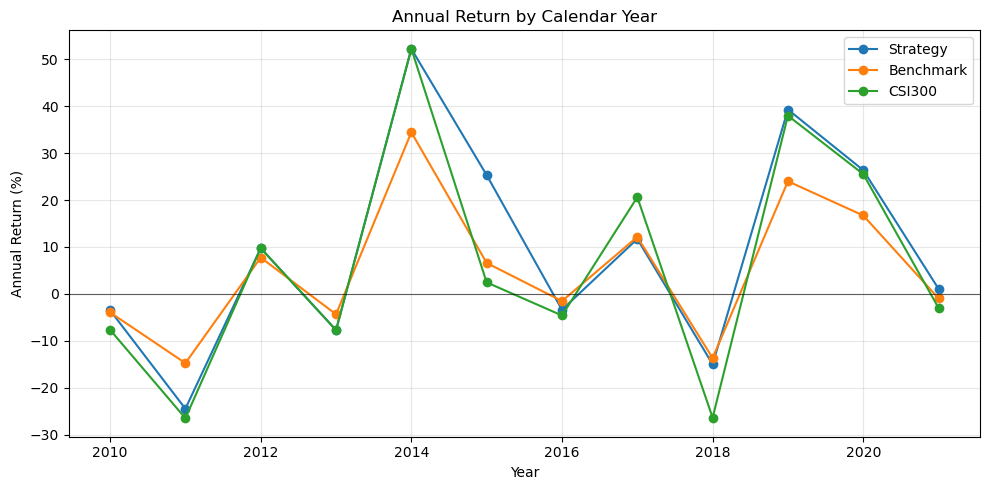

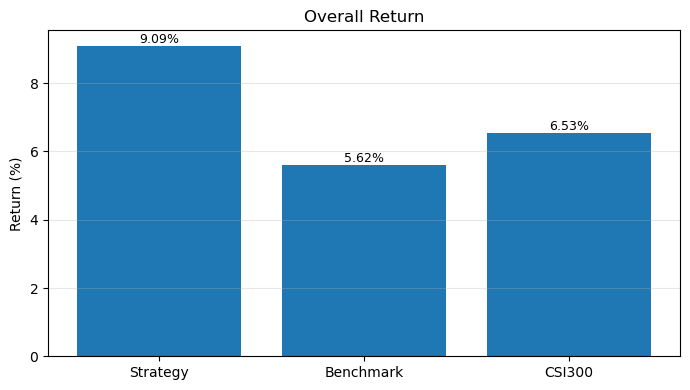

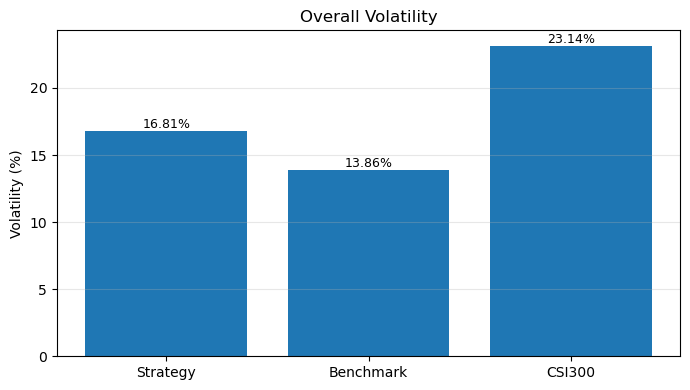

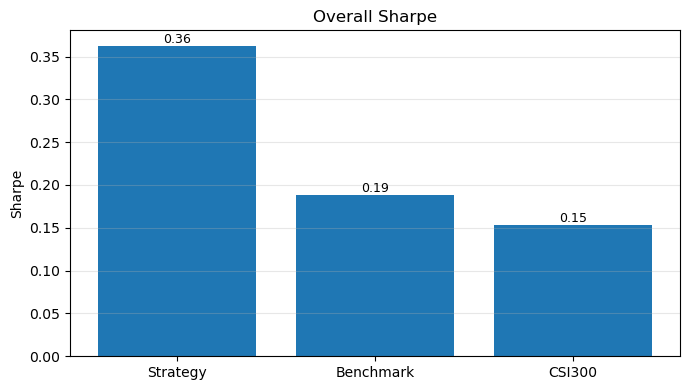

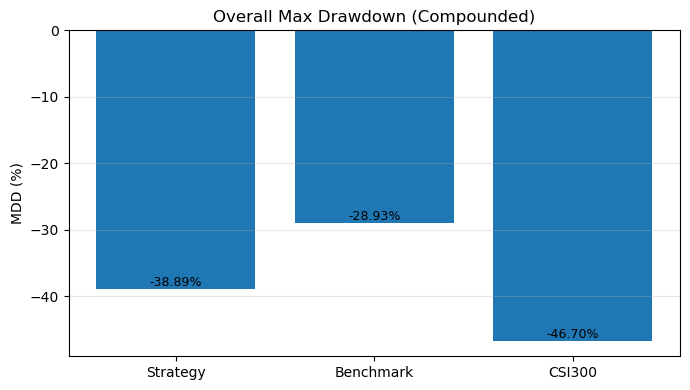

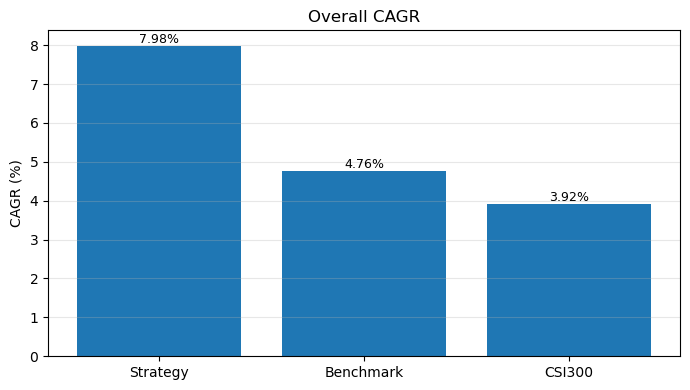


Overall summary:
          Return Volatility Sharpe      MDD   CAGR
Label                                             
Strategy   9.09%     16.81%   0.36  -38.89%  7.98%
Benchmark  5.62%     13.86%   0.19  -28.93%  4.76%
CSI300     6.53%     23.14%   0.15  -46.70%  3.92%

Yearly AnnualReturn (wide):
      Strategy  Benchmark  CSI300
Year                             
2010     -3.48      -3.93   -7.64
2011    -24.44     -14.72  -26.46
2012      9.75       7.75    9.75
2013     -7.70      -4.33   -7.70
2014     52.18      34.41   52.19
2015     25.30       6.60    2.46
2016     -3.37      -1.52   -4.58
2017     11.71      12.14   20.60
2018    -14.98     -13.65  -26.34
2019     39.26      23.99   37.95
2020     26.34      16.70   25.51
2021      1.09      -0.94   -2.98


In [580]:
yearly_wide, overall = compare_from_yearly_tables(strategy_df=perf_strategy,
                                                    benchmark_df=perf_benchmark,
                                                    csi300_df=perf_csi300)